## Paediatric Pneumonia Detection Models: Using Both Non-Visual Data (Patient Information) and Visual Data (Chest X-rays)

### Introduction

In this project, we will begin by developing a model based solely on *non-visual data*, specifically patient information, organized in a CSV format. This initial step will involve analyzing and processing this data to build a robust predictive model for detecting paediatric pneumonia. Following this, we will create a separate model focused on *visual data*, utilizing chest X-rays to enhance diagnostic accuracy through image analysis.

Once these two individual models are established, we will integrate both data types to develop a *combined model*. This integrated approach aims to leverage the strengths of both non-visual and visual data, potentially improving the overall detection accuracy and providing a more comprehensive diagnostic tool for paediatric pneumonia.

### Dataset Information:

#### 1. Non- Visual Pateint Data
This Dataset was obtained from Kaggle.com.

This contains around 110 lines of patient data. This patient data includes features such as patient ID, age, gender, weight, height, whether the patient is asthmatic, residence (rural or urban), whether a cough is present, whether they have pneumonia, oxygen saturation, temperature, symptoms, CRP.

#### 2. Visual Pateint Data (chest-x ray images)

This dataset, sourced from Kaggle.com, comprises 5,863 X-ray images in JPEG format, categorized into pneumonia and normal cases. It is structured into three subsets: train, validation, and test. Considering the limited size of the validation set (comprising only 16 images), it will be merged into the test set. The model will be exclusively trained using the training subset.

The chest X-ray images (anterior-posterior) were gathered from retrospective cohorts of pediatric patients aged one to five years at Guangzhou Women and Children’s Medical Center, Guangzhou. These images were part of routine clinical procedures.

### Importing libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn import model_selection
from skimage import color, exposure
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from glob import glob
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import time
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

print("Library and module imports have completed.")


Library and module imports have completed.


### Non-Visual Data (Patient Information in CSV) 

#### 1. Load Data

**Objective:** Import and prepare the dataset for analysis.

**Dataset Import:** The dataset containing patient information is loaded from a CSV file using pandas. Column names are explicitly defined to ensure the data is correctly labeled and structured.
Validation: A confirmation message is printed to verify that the dataset has been imported successfully, indicating that the data is ready for further processing.

In [2]:
# Import the dataset on patient data
csv_file_path = './pneumonia_data.csv' 

# Define column names for the pandas DataFrame
column_headings = ['patient_id', 'age', 'gender', 'weight', 'height', 'asthmatic', 'residence', 'cough_present', 'pneumonia', 'oxygen_saturation', 'temperature', 'symptoms', 'CRP']

# Read the CSV data
patient_data = pd.read_csv(csv_file_path, names=column_headings)

#Confirm the data has been imported successfully
print("Dataset has been imported successfully!")

Dataset has been imported successfully!


#### 2. Visualise CSV Patient Data

**Objective:** Perform exploratory data analysis (EDA) to understand the dataset through visualizations and statistical summaries.

- **Basic Information:** The .info() method is used to display the DataFrame's summary, including the number of non-null entries and data types for each column. This helps in assessing the completeness and data types.
- **Dataset Dimensions:** The number of columns and rows in the dataset is calculated and printed to provide an overview of its size and structure.
- **Initial Data Inspection:** The first row of the DataFrame is printed to inspect the data format and content, followed by displaying the first 15 rows to get a preliminary view of the dataset.
- **Display Settings:** Pandas display options are adjusted to enhance readability by ensuring all columns are visible and the DataFrame format is suitable for viewing.
- **Pneumonia Case Distribution:** The .value_counts() method is used to count the occurrences of each value in the 'pneumonia' column, providing insights into the distribution of pneumonia cases within the dataset.
- **Filtered Data:** A subset of the data for patients with pneumonia is created, and the first 15 rows of this subset are displayed to focus on the specific group of interest.
- **Feature Visualization:**
    - *Scatter Plots:* Scatter plots are created to visualize the relationship between various features and pneumonia status. Different colors are used to distinguish between patients with and without pneumonia.
    - *Box Plots:* Box plots are generated to show the distribution of features and detect any outliers, comparing patients with and without pneumonia.
    - *Histogram:* A histogram is plotted to show the age distribution of patients with pneumonia, helping to understand the age range and frequency.
    - *Bar Chart:* A bar chart is used to display the gender distribution among patients with pneumonia, revealing any gender imbalances.
    - *Pie Chart:* A pie chart illustrates the residence distribution of patients with pneumonia, identifying any geographic trends.
    - *Line Plot:* A line plot shows the variation in temperature over patient IDs for those with pneumonia, exploring any potential patterns.
    - *Heatmap:* A heatmap is created to visualize the correlation matrix of numeric features among patients with pneumonia, highlighting potential relationships between features.

In [3]:
# Display the breakdown of the DataFrame
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patient_id         180 non-null    int64  
 1   age                180 non-null    int64  
 2   gender             180 non-null    object 
 3   weight             180 non-null    float64
 4   height             180 non-null    int64  
 5   asthmatic          180 non-null    object 
 6   residence          180 non-null    object 
 7   cough_present      180 non-null    object 
 8   pneumonia          180 non-null    object 
 9   oxygen_saturation  180 non-null    int64  
 10  temperature        180 non-null    float64
 11  symptoms           180 non-null    object 
 12  CRP                180 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 18.4+ KB


In [4]:
# Determine the number of columns and rows in the dataset
# Number of columns
columns_data_num = len(patient_data.columns)
print("Total number of columns in the dataset:", columns_data_num)

# Number of rows
rows_data_num = len(patient_data)
print("Total number of rows in the dataset:", rows_data_num)

Total number of columns in the dataset: 13
Total number of rows in the dataset: 180


In [5]:
# Display the shape of the DataFrame to show the number of features and examples
shape_data = patient_data.shape
print("DataFrame shape:", shape_data)

DataFrame shape: (180, 13)


In [6]:
# Print the first row of the DataFrame
print("Example row:")
print(patient_data.loc[0])

Example row:
patient_id               1
age                      3
gender                male
weight                15.2
height                 100
asthmatic               no
residence            rural
cough_present           no
pneumonia               no
oxygen_saturation       98
temperature           37.0
symptoms              none
CRP                      5
Name: 0, dtype: object


In [7]:
# Select the first 15 rows of the data
first_data_15 = patient_data.head(15)

# Adjust the maximum column width (improve readability)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

# Display the first 15 rows of the DataFrame
first_data_15

,patient_id,age,gender,weight,height,asthmatic,residence,cough_present,pneumonia,oxygen_saturation,temperature,symptoms,CRP
0,1,3,male,15.2,100,no,rural,no,no,98,37.0,none,5
1,2,4,female,18.1,105,yes,urban,yes,yes,92,38.2,"coughing, weakness",150
2,3,2,male,12.5,90,yes,rural,yes,yes,93,37.9,"coughing, chest pain, difficulty breathing",160
3,4,5,female,20.0,110,no,urban,no,no,99,36.8,none,10
4,5,3,male,14.0,95,yes,urban,yes,yes,96,37.1,"coughing, appetite loss",20
5,6,1,female,10.5,80,no,rural,no,no,98,36.9,none,8
6,7,2,male,13.2,85,yes,urban,yes,yes,91,38.0,"coughing, weakness, chest pain",145
7,8,4,female,17.5,102,no,rural,yes,no,97,37.0,"coughing, difficulty breathing",15
8,9,5,male,21.0,115,yes,urban,yes,yes,90,38.3,"coughing, weakness, difficulty breathing, appe...",170
9,10,3,female,16.0,98,no,rural,no,no,98,36.7,none,5


In [8]:
# Confirm how many patients have pneumonia
print(patient_data['pneumonia'].value_counts())

# Filter and display data for patients with pneumonia
pneumonia_data = patient_data[patient_data['pneumonia'] == 'yes']

# Adjust the maximum column width (improve readability)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

# Select the first 15 rows of the data
first_data_15 = pneumonia_data.head(15)
# Display the first 15 rows of the DataFrame
first_data_15

pneumonia
no     95
yes    85
Name: count, dtype: int64


,patient_id,age,gender,weight,height,asthmatic,residence,cough_present,pneumonia,oxygen_saturation,temperature,symptoms,CRP
1,2,4,female,18.1,105,yes,urban,yes,yes,92,38.2,"coughing, weakness",150
2,3,2,male,12.5,90,yes,rural,yes,yes,93,37.9,"coughing, chest pain, difficulty breathing",160
4,5,3,male,14.0,95,yes,urban,yes,yes,96,37.1,"coughing, appetite loss",20
6,7,2,male,13.2,85,yes,urban,yes,yes,91,38.0,"coughing, weakness, chest pain",145
8,9,5,male,21.0,115,yes,urban,yes,yes,90,38.3,"coughing, weakness, difficulty breathing, appe...",170
10,11,2,male,11.8,88,yes,urban,yes,yes,92,38.1,"coughing, chest pain",155
14,15,3,male,14.8,99,yes,urban,yes,yes,91,38.0,"coughing, weakness, chest pain",140
16,17,4,male,18.5,103,yes,urban,yes,yes,90,38.2,"coughing, difficulty breathing, appetite loss",175
18,19,3,male,13.7,96,yes,urban,yes,yes,92,38.3,"coughing, chest pain, difficulty breathing",160
20,21,4,male,19.5,108,yes,urban,yes,yes,91,38.1,"coughing, weakness",150


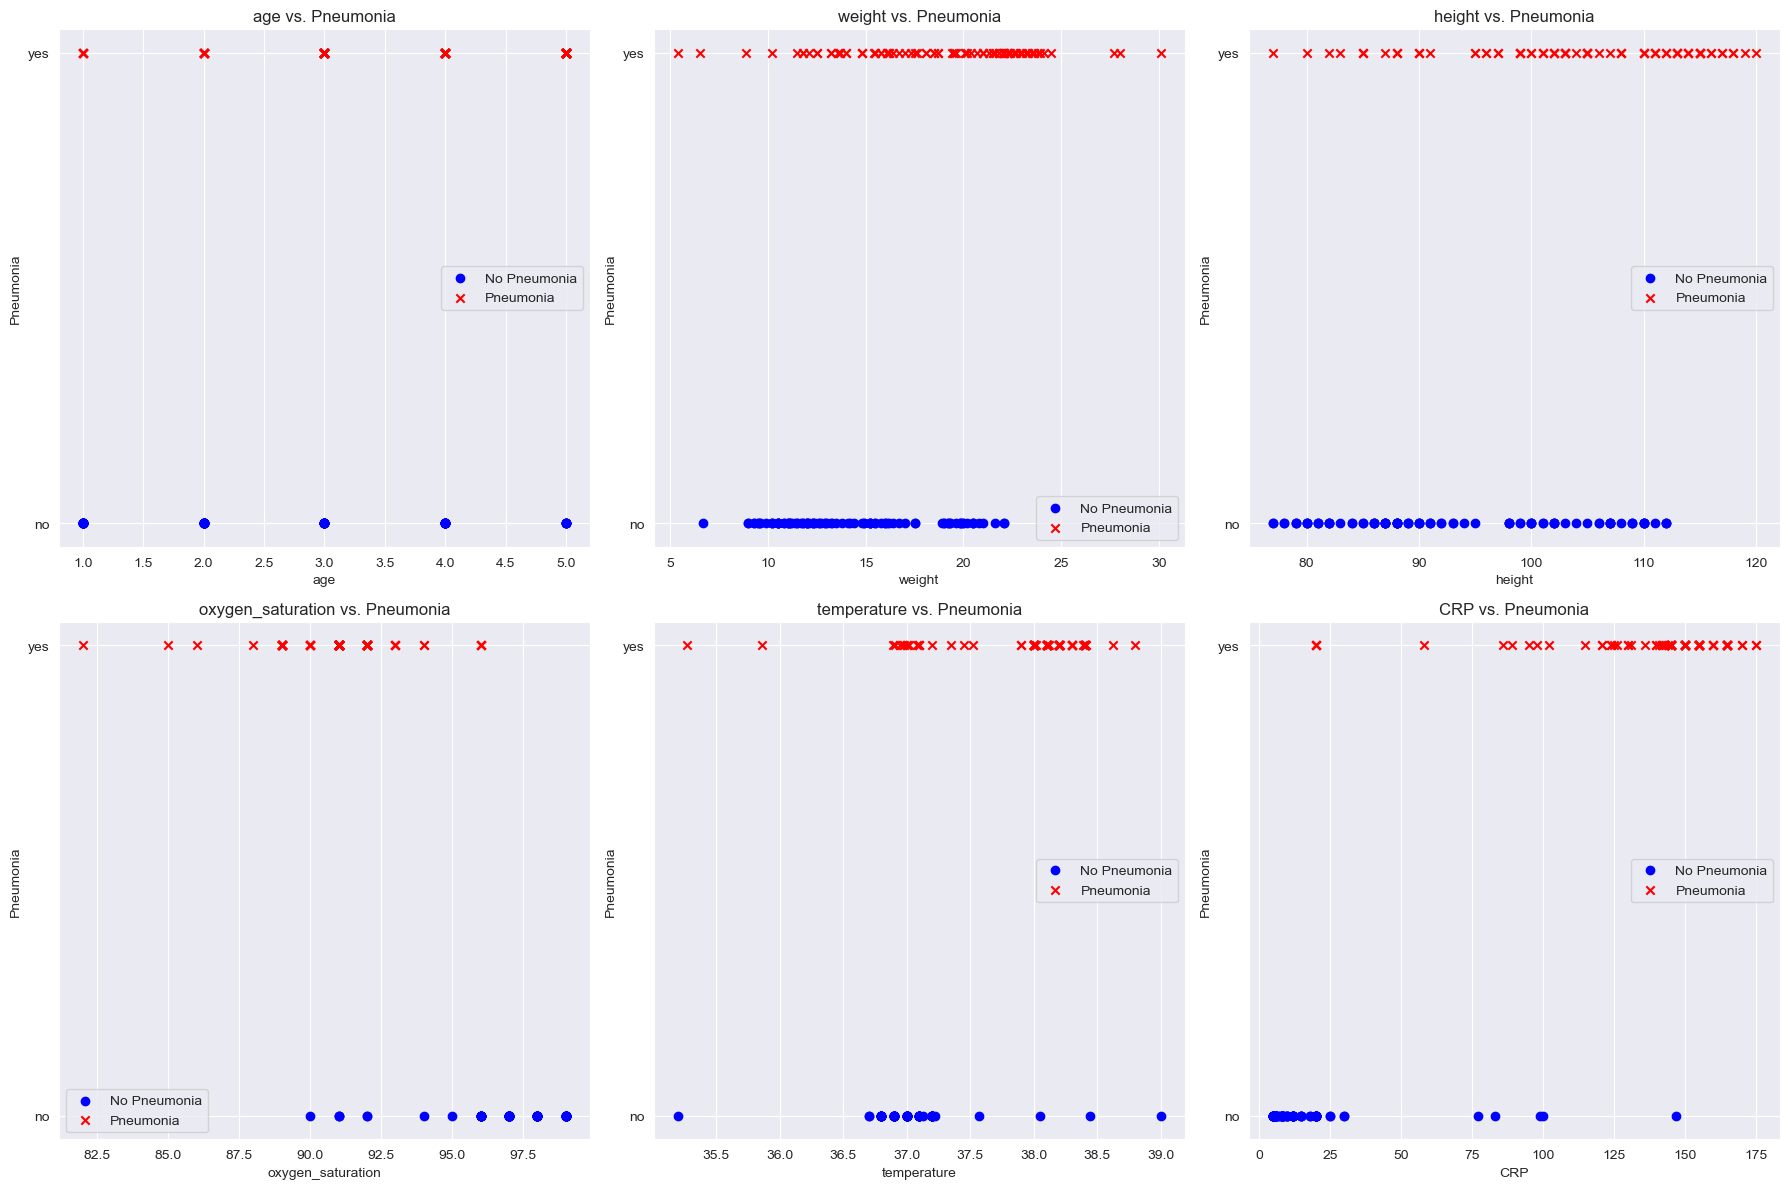

In [9]:
# Define a list of features to create meaningful plots
features = ['age', 'weight', 'height', 'oxygen_saturation', 'temperature', 'CRP']

# Calculate the number of rows and columns for the grid
num_rows = 2
num_cols = 3

# Create subplots in a grid layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12), constrained_layout=True)

# Flatten the axes array to iterate through
axes = axes.flatten()

# Loop through the features and create scatter plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(patient_data[feature][patient_data['pneumonia'] == 'no'], patient_data['pneumonia'][patient_data['pneumonia'] == 'no'], c='blue', label='No Pneumonia', marker='o')
    ax.scatter(patient_data[feature][patient_data['pneumonia'] == 'yes'], patient_data['pneumonia'][patient_data['pneumonia'] == 'yes'], c='red', label='Pneumonia', marker='x')
    ax.set_title(f'{feature} vs. Pneumonia')
    ax.set_xlabel(feature)
    ax.set_ylabel('Pneumonia')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [10]:
# Convert 'pneumonia' column to categorical type
patient_data['pneumonia'] = patient_data['pneumonia'].astype('category')

# Convert 'asthmatic' column to numeric (binary)
patient_data['asthmatic'] = patient_data['asthmatic'].apply(lambda x: 1 if x == 'yes' else 0)

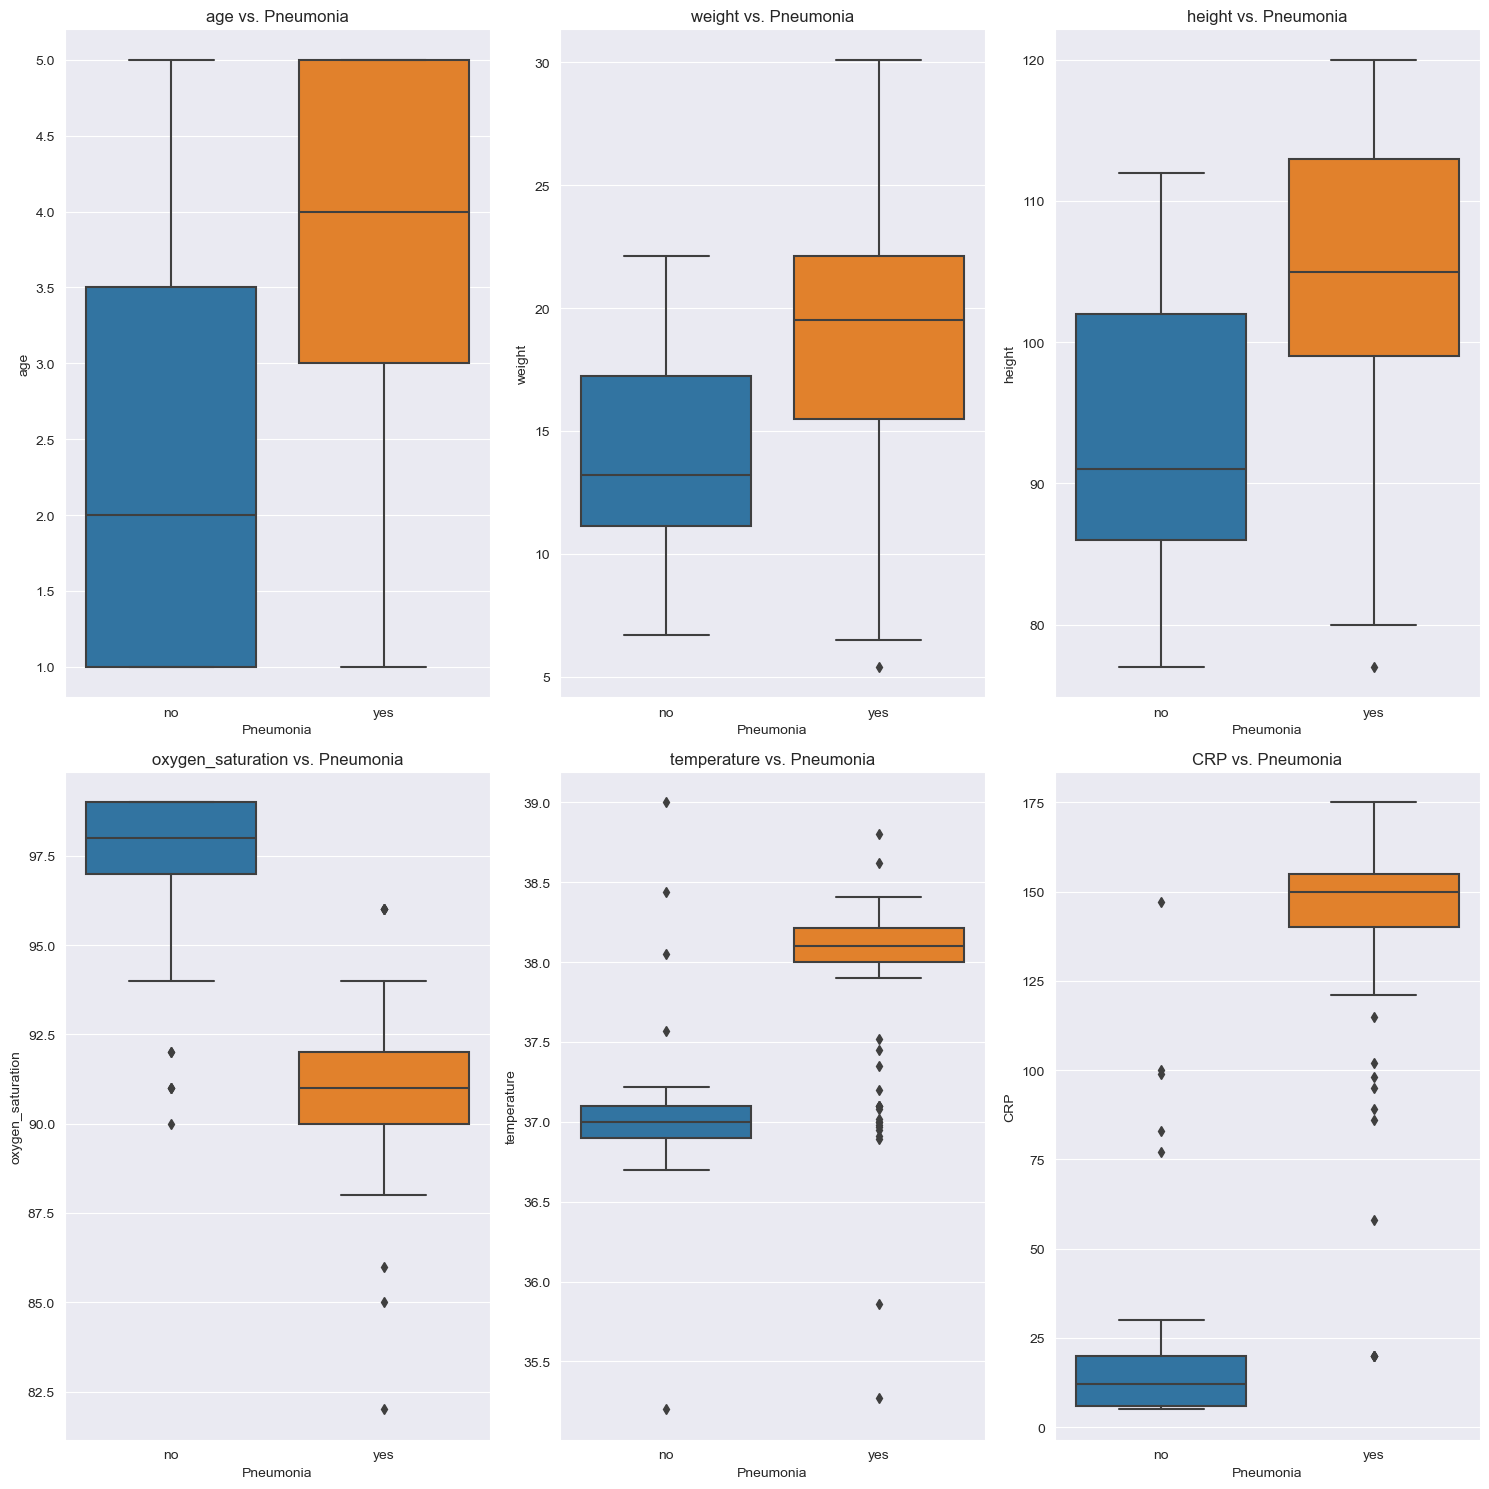

In [11]:
# Define a list of features to create box plots for
features = ['age', 'weight', 'height', 'oxygen_saturation', 'temperature', 'CRP']

# Ensure all feature columns are numeric
for feature in features:
    patient_data[feature] = pd.to_numeric(patient_data[feature], errors='coerce')

# Calculate the number of rows and columns for the grid
num_rows = 2
num_cols = 3

# Create subplots in a grid layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes array to iterate through
axes = axes.flatten()

# Loop through the features and create box plots
for i, feature in enumerate(features):
    ax = axes[i]
    sns.boxplot(x='pneumonia', y=feature, data=patient_data, ax=ax)
    ax.set_title(f'{feature} vs. Pneumonia')
    ax.set_xlabel('Pneumonia')
    ax.set_ylabel(feature)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

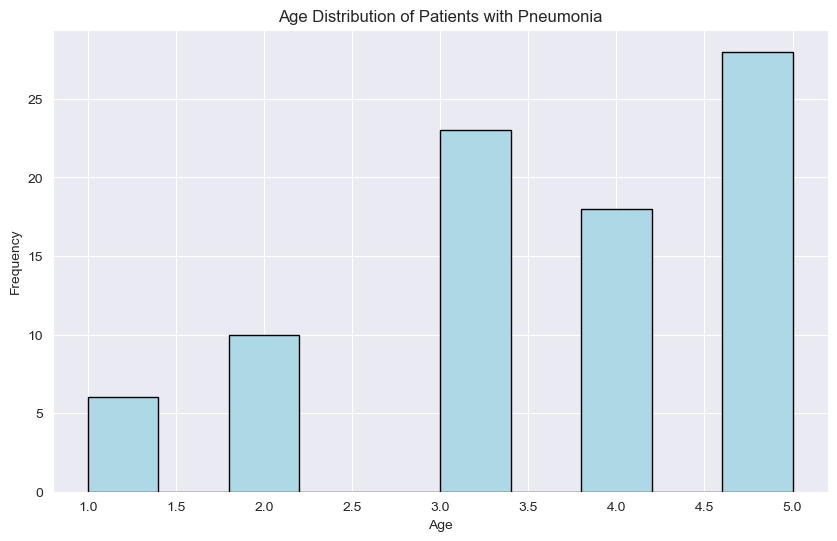

In [12]:
# Histogram - Age Distribution of Patients with Pneumonia
plt.figure(figsize=(10, 6))
plt.hist(patient_data['age'][patient_data['pneumonia'] == 'yes'], bins=10, color='lightblue', edgecolor='black')
plt.title('Age Distribution of Patients with Pneumonia')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

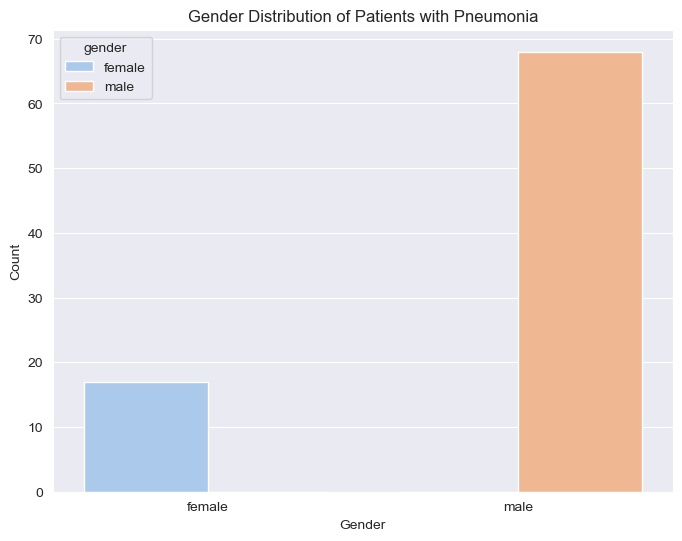

In [13]:
# Bar Chart - Gender Distribution of Patients with Pneumonia
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=patient_data[patient_data['pneumonia'] == 'yes'], palette='pastel', hue='gender')
plt.title('Gender Distribution of Patients with Pneumonia')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

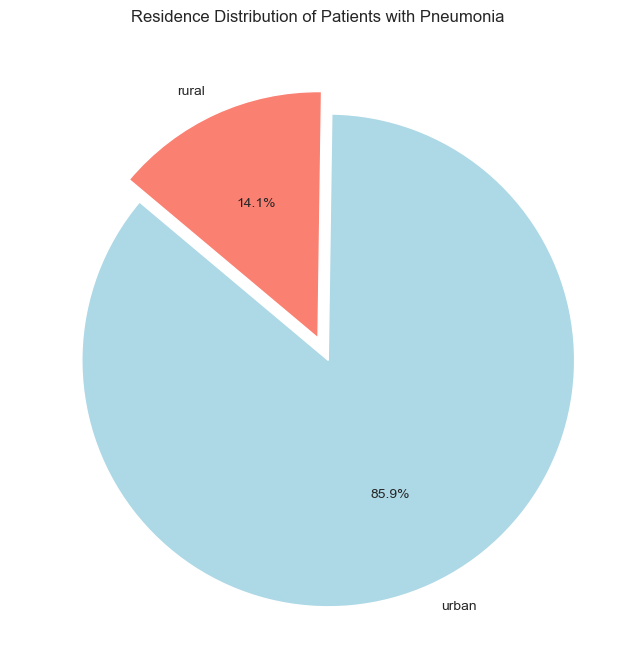

In [14]:
# Pie Chart - Residence Distribution of Patients with Pneumonia
plt.figure(figsize=(8, 8))
patient_data['residence'][patient_data['pneumonia'] == 'yes'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'salmon'], explode=(0.1, 0), startangle=140)
plt.title('Residence Distribution of Patients with Pneumonia')
plt.ylabel('')
plt.show()

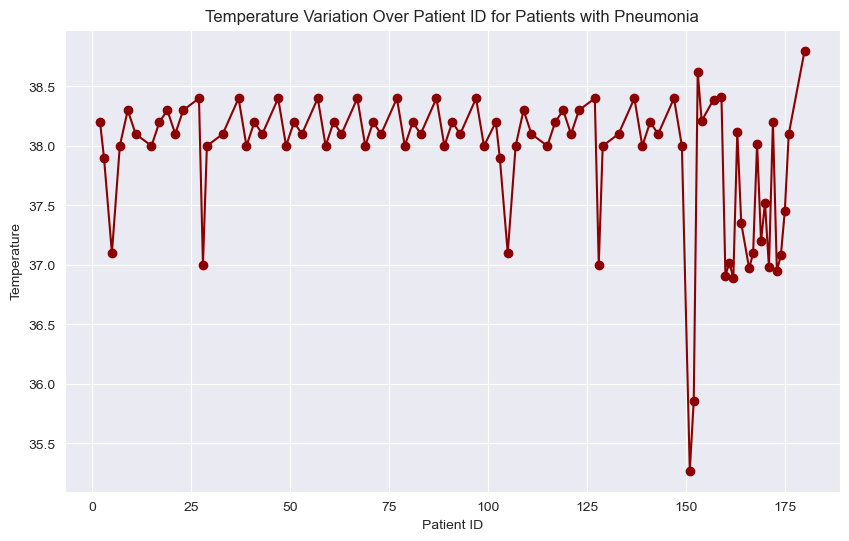

In [15]:
# Line Plot - Temperature Variation Over Patient ID for Patients with Pneumonia
plt.figure(figsize=(10, 6))
plt.plot(patient_data['patient_id'][patient_data['pneumonia'] == 'yes'], patient_data['temperature'][patient_data['pneumonia'] == 'yes'], marker='o', color='darkred')
plt.title('Temperature Variation Over Patient ID for Patients with Pneumonia')
plt.xlabel('Patient ID')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

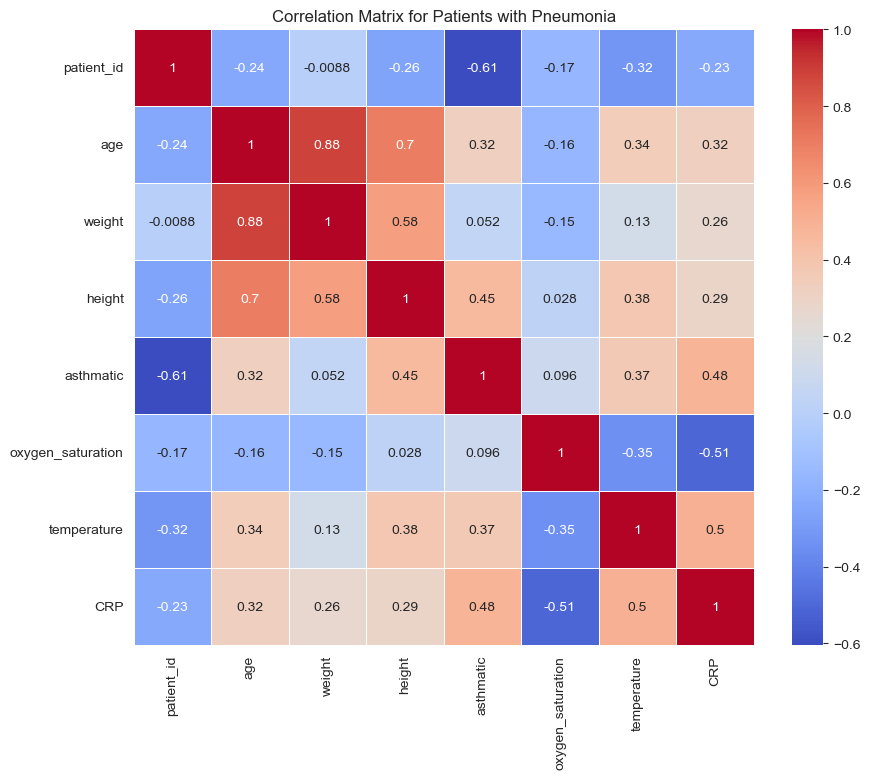

In [16]:
# Heatmap - Correlation Matrix for Patients with Pneumonia
plt.figure(figsize=(10, 8))
numeric_data = patient_data[patient_data['pneumonia'] == 'yes'].select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Patients with Pneumonia')
plt.show()

#### 3. Model Architecture - Prepare Data for Training

**Objective:** Preprocess the data to make it suitable for machine learning models.

- **Categorical Data Encoding:** Categorical variables are converted into numeric format using label encoding to prepare them for machine learning algorithms.
- **Feature and Target Preparation:**
    - *For CSV Data:* Features are prepared by excluding non-feature columns and scaling the feature values.
    - *For Classification:* The feature matrix (X) and target vector (Y) are defined for classification tasks.
- **Feature Standardization:** Standard scaling is applied to normalize feature values, improving model performance and convergence.
- **Data Splitting:** The dataset is divided into training and testing sets to evaluate the model’s performance on unseen data.
- **Label Encoding:** Target labels are converted into categorical format using one-hot encoding for classification tasks.
- **Feature Scaling:** Min-Max scaling is applied to ensure feature values are within the range [0, 1], aiding in effective model training.
- **Binary Classification Labels:** Target labels are converted to binary format to indicate the presence or absence of pneumonia.

In [17]:
# Encode categorical data and scale numerical features
categorical_cols = ['gender', 'asthmatic', 'residence', 'cough_present', 'symptoms', 'pneumonia']
for col in categorical_cols:
    patient_data[col] = LabelEncoder().fit_transform(patient_data[col])

# Prepare features and target for CSV data
X_csv = patient_data.drop(columns=categorical_cols + ['CRP', 'patient_id']).values
y_csv = patient_data['CRP'].values

# Standardize CSV data
scaler = StandardScaler()
X_csv = scaler.fit_transform(X_csv)

In [18]:
# Prepare the Data for training

# Create X and Y datasets for training
# Use 'pneumonia' column as the target variable
X = np.array(patient_data.drop(['pneumonia'], axis=1))
Y = np.array(patient_data['pneumonia'])

# Check the unique values in the target column to ensure they are suitable for modeling
print("Unique values in target column:", np.unique(Y))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

# Print that the split has been done successfully wit sample sizes
print("Data has been split into training and testing sets successfully!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Unique values in target column: [0 1]
Data has been split into training and testing sets successfully!
Training set size: 144 samples
Testing set size: 36 samples


In [19]:
# Convert the training and testing target labels to categorical labels using TensorFlow
categorical_Y_train = to_categorical(y_train, num_classes=None)
categorical_Y_test = to_categorical(y_test, num_classes=None)

# Print the shape and the first 10 rows of categorical_Y_train
print(categorical_Y_train.shape)
print(categorical_Y_train[:10])

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the scaler on your training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test features using the same scaler
X_test_scaled = scaler.transform(X_test)

# Copy target labels
Y_train_binary = y_train.copy()
Y_test_binary = y_test.copy()

# Replace values greater than 0 with 1 to indicate pneumonia, and keep 0 for no pneumonia
Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1

# Display the first 25 values of the converted binary labels in Y_train_binary
print("First 25 entries in Y_train_binary:")
print(Y_train_binary[:25])

(144, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
First 25 entries in Y_train_binary:
[0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0]


#### 4. Train Model

**Objective:** Train and evaluate different machine learning models.

- **Baseline Model - Random Classifier:** A dummy classifier that makes random predictions is created to establish a baseline for comparison. This model does not require fitting since it generates random predictions.
- **Improved Neural Network Model:**
    - *Model Architecture:* A neural network is constructed with the following layers:
        - *Dense Layers:* Fully connected layers with ReLU activation to capture complex patterns.
        - *BatchNormalization:* Applied to normalize activations and stabilize training.
        - *Dropout:* Used to reduce overfitting by randomly dropping units during training.
        - *Output Layer:* A softmax activation function is used to predict class probabilities.
- **Model Compilation:** The model is compiled with the Adam optimizer and categorical crossentropy loss function, and metrics are set to accuracy.
- **Model Training:** The model is trained on the scaled training data with a validation split, tracking performance over epochs.

In [20]:
#Baseline Models
# Random Classifier Model
# Create a DummyClassifier that predicts randomly
random_model = DummyClassifier(strategy="uniform")

# Fit the model (no need for fitting actually, as it's random)
random_model.fit(X_train_scaled, Y_train_binary)

# Make predictions on the test set
predictions = random_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(Y_test_binary, predictions)
print(f"Random Model Accuracy: {accuracy * 100:.2f}%")

Random Model Accuracy: 52.78%


In [21]:
# Improved Sequential Model
# Initialize improved model
improved_nn_model = Sequential()
improved_nn_model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
improved_nn_model.add(BatchNormalization())
improved_nn_model.add(Dropout(0.5))
improved_nn_model.add(Dense(64, activation='relu'))
improved_nn_model.add(BatchNormalization())
improved_nn_model.add(Dropout(0.5))
improved_nn_model.add(Dense(32, activation='relu'))
improved_nn_model.add(Dense(2, activation='softmax'))

# Compile the improved model
improved_nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the improved model
history = improved_nn_model.fit(X_train_scaled, categorical_Y_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30


5/5 [==============================] - 4s 149ms/step - loss: 1.0856 - accuracy: 0.4031 - val_loss: 0.6893 - val_accuracy: 0.5333
Epoch 2/30
5/5 [==============================] - 0s 24ms/step - loss: 0.8132 - accuracy: 0.5969 - val_loss: 0.6691 - val_accuracy: 0.6667
Epoch 3/30
5/5 [==============================] - 0s 22ms/step - loss: 0.5854 - accuracy: 0.7519 - val_loss: 0.6474 - val_accuracy: 0.7333
Epoch 4/30
5/5 [==============================] - 0s 22ms/step - loss: 0.4417 - accuracy: 0.8062 - val_loss: 0.6291 - val_accuracy: 0.7333
Epoch 5/30
5/5 [==============================] - 0s 23ms/step - loss: 0.4007 - accuracy: 0.8217 - val_loss: 0.6128 - val_accuracy: 0.7333
Epoch 6/30
5/5 [==============================] - 0s 22ms/step - loss: 0.3575 - accuracy: 0.8295 - val_loss: 0.6021 - val_accuracy: 0.7333
Epoch 7/30
5/5 [==============================] - 0s 23ms/step - loss: 0.3534 - accuracy: 0.8450 - val_loss: 0.5937 - val_accuracy: 0.7333
Epoch 8/30
5/5 [=======

#### 5. Evaluate Model / Results

**Objective:** Assess the performance of the trained model and interpret the results.

- **Model Evaluation:** The trained neural network model is evaluated on the test set to measure accuracy and loss, providing insight into its performance on unseen data.
- **Predictions and Metrics:**
    - *Prediction:* Predictions are made on the test set, and class labels are obtained by converting predicted probabilities to class labels.
    - *Confusion Matrix:* A confusion matrix is computed to visualize the performance of the model in classifying pneumonia cases versus non-cases.
    - *Classification Report:* A classification report is generated to provide detailed metrics such as precision, recall, and F1-score for each class.
- **Training Metrics Visualization:**
    - *Loss Plot:* Training and validation loss are plotted to observe learning progress and detect overfitting.
    - *Accuracy Plot:* Training and validation accuracy are plotted to visualize model improvement and assess its performance over epochs.

In [22]:
# Evaluate the improved model
loss, accuracy = improved_nn_model.evaluate(X_test_scaled, categorical_Y_test)
print(f"Improved Neural Network Accuracy: {accuracy * 100:.2f}%")

2/2 [==============================] - 0s 8ms/step - loss: 0.2443 - accuracy: 0.8889
Improved Neural Network Accuracy: 88.89%


In [23]:
# Make predictions on the test set
y_pred = improved_nn_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_test_classes = np.argmax(categorical_Y_test, axis=1)

2/2 [==============================] - 0s 2ms/step


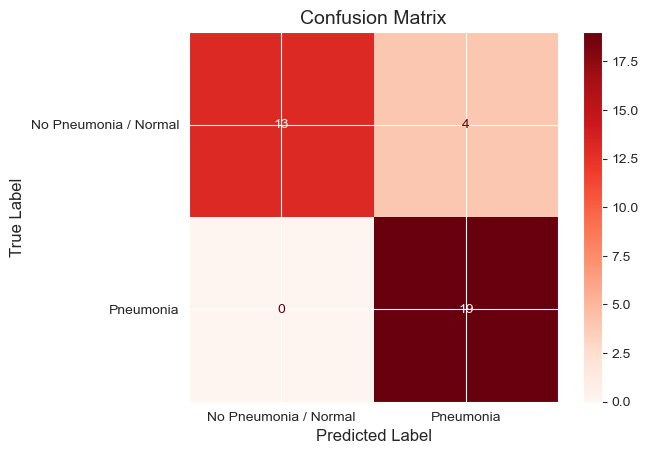

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Pneumonia / Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Reds, values_format='d')

# Customize font sizes
plt.title('Confusion Matrix', fontsize=14)  
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)  
disp.ax_.set_xlabel('Predicted Label', fontsize=12) 
disp.ax_.set_ylabel('True Label', fontsize=12) 

# Adjust the colorbar size
cbar = disp.im_.colorbar

plt.show()

In [25]:
# Print classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['No Pneumonia', 'Pneumonia'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

No Pneumonia       1.00      0.76      0.87        17
   Pneumonia       0.83      1.00      0.90        19

    accuracy                           0.89        36
   macro avg       0.91      0.88      0.89        36
weighted avg       0.91      0.89      0.89        36



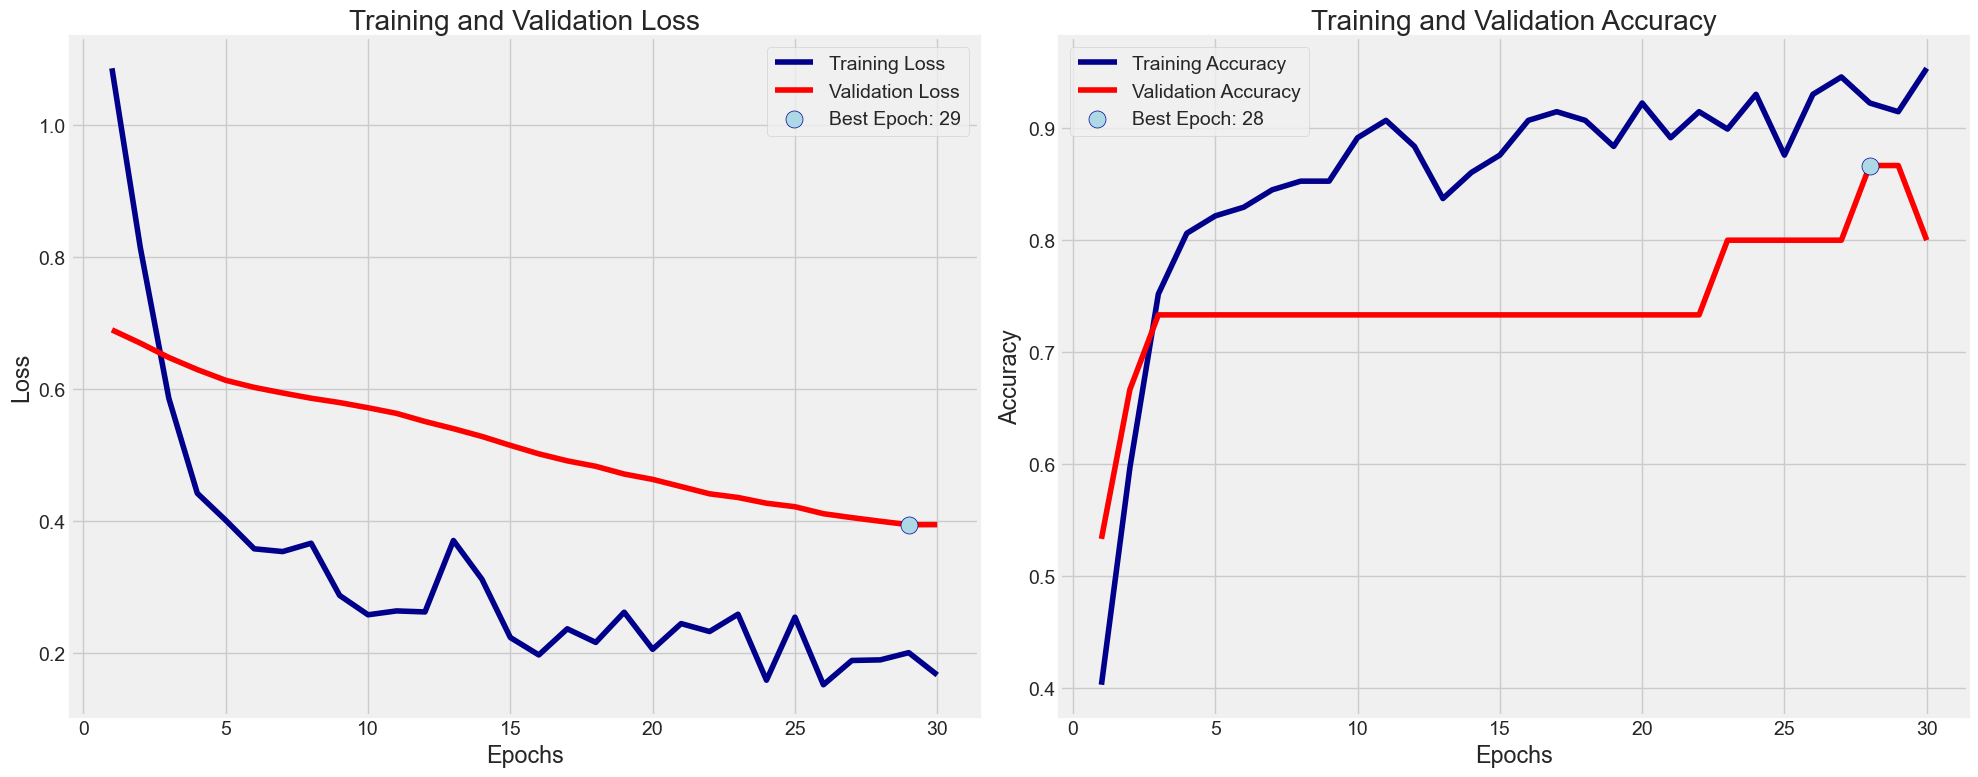

In [26]:
# Extract accuracy and loss from the training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find the index of the best epoch for validation loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create labels for the best epoch
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best Epoch: {index_loss + 1}'
acc_label = f'Best Epoch: {index_acc + 1}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Subplot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color='darkblue', label='Training Loss')
plt.plot(Epochs, val_loss, color='red', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='lightblue', edgecolor='darkblue', label=loss_label, zorder=5)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color='darkblue', label='Training Accuracy')
plt.plot(Epochs, val_acc, color='red', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='lightblue', edgecolor='darkblue', label=acc_label, zorder=5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Visual Data (Chest X-Ray Images) 

#### 1. Preprocessing Train Dataset

**Objective:** Load and prepare the training dataset for model training.

**Load Data Path Procedure:**
- List subfolders (NORMAL and PNEUMONIA) and get image file paths and labels.
- Create a DataFrame with filepaths and labels.

**Visualize Sample Images:**
- Load and display one image from each class (NORMAL and PNEUMONIA).

In [27]:
# Preprocessing Train Dataset
train_data_path = './chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

# Get list of subfolders in the train dataset directory
folds = os.listdir(train_data_path)
for fold in folds:
    foldpath = os.path.join(train_data_path, fold)
    filelist = os.listdir(foldpath)
    
    # Add file paths and corresponding labels
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Create a DataFrame from the filepaths and labels      
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [28]:
# Display the DataFrame
print(df.head())

                                           filepaths   label
0  ./chest-xray-pneumonia/chest_xray/train\NORMAL...  NORMAL
1  ./chest-xray-pneumonia/chest_xray/train\NORMAL...  NORMAL
2  ./chest-xray-pneumonia/chest_xray/train\NORMAL...  NORMAL
3  ./chest-xray-pneumonia/chest_xray/train\NORMAL...  NORMAL
4  ./chest-xray-pneumonia/chest_xray/train\NORMAL...  NORMAL


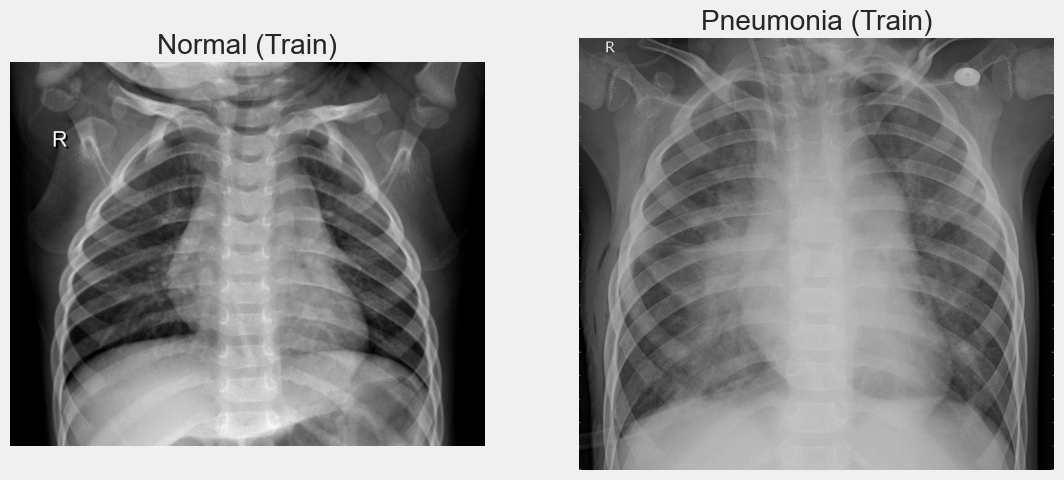

In [29]:
# Load the images
train_img_norm = load_img(train_data_path +"/NORMAL/IM-0117-0001.jpeg")
train_img_pne = load_img(train_data_path +"/PNEUMONIA/person12_bacteria_47.jpeg")

# Create a subplot with larger images (increased figsize)
plt.figure(figsize=(12, 6))  # Increase the figure size (width, height)

# Display the normal image
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(train_img_norm)
plt.title('Normal (Train)')
plt.axis('off')  # Hide axes for better visualization

# Display the pneumonia image
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(train_img_pne)
plt.title('Pneumonia (Train)')
plt.axis('off')  # Hide axes

# Show the plot with both images side by side
plt.show()


#### Preprocessing Validation Dataset

**Objective:** Load and prepare the validation dataset.

**Load Data Procedure:**
- Similar to training, list subfolders, get image file paths and labels, and create a DataFrame.

**Visualize Sample Images:**
- Load and display one image from each class (NORMAL and PNEUMONIA).

In [30]:
# Preprocessing Validation Dataset
valid_data_dir = './chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

# Get list of subfolders in the train dataset directory
folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    # Add file paths and corresponding labels
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create a DataFrame from the filepaths and labels        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [31]:
# Display the DataFrame
print(valid.head())

                                           filepaths   label
0  ./chest-xray-pneumonia/chest_xray/val\NORMAL\N...  NORMAL
1  ./chest-xray-pneumonia/chest_xray/val\NORMAL\N...  NORMAL
2  ./chest-xray-pneumonia/chest_xray/val\NORMAL\N...  NORMAL
3  ./chest-xray-pneumonia/chest_xray/val\NORMAL\N...  NORMAL
4  ./chest-xray-pneumonia/chest_xray/val\NORMAL\N...  NORMAL


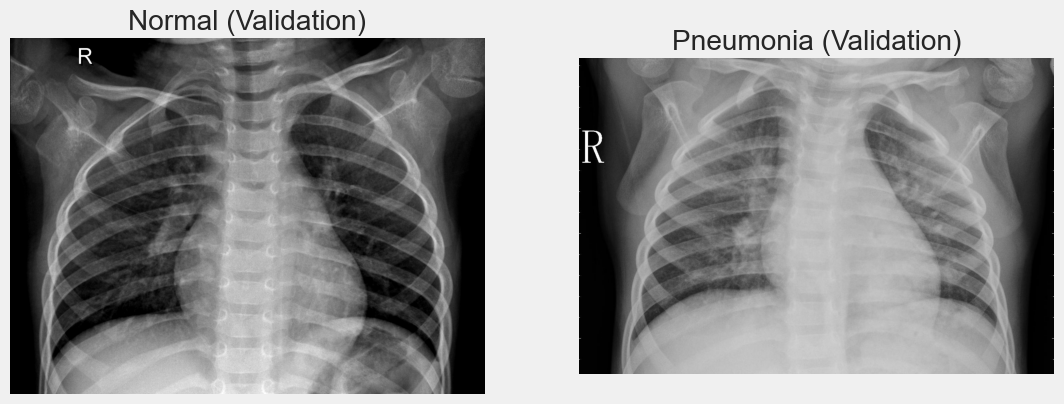

In [32]:
# Load the images
valid_img_norm = load_img(valid_data_dir +"/NORMAL/NORMAL2-IM-1440-0001.jpeg")
valid_img_pne = load_img(valid_data_dir +"/PNEUMONIA/person1949_bacteria_4880.jpeg")

# Create a subplot with larger images (increased figsize)
plt.figure(figsize=(12, 6))  # Increase the figure size (width, height)

# Display the normal validation image
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(valid_img_norm)
plt.title('Normal (Validation)')
plt.axis('off')  # Hide axes for better visualization

# Display the pneumonia validation image
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(valid_img_pne)
plt.title('Pneumonia (Validation)')
plt.axis('off')  # Hide axes

# Show the plot with both images side by side
plt.show()

#### Preprocessing Test Dataset

**Objective:** Load and prepare the test dataset.

**Load Data Procedure:**
- Similar to training and validation, list subfolders, get image file paths and labels, and create a DataFrame.

**Visualize Sample Images:**
- Load and display one image from each class (NORMAL and PNEUMONIA).

In [33]:
# Preprocessing Test Dataset
test_data_dir = './chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

# Get list of subfolders in the train dataset directory
folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    # Add file paths and corresponding labels
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Create a DataFrame from the filepaths and labels
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)

In [34]:
# Display the DataFrame
print(test.head())

                                           filepaths   label
0  ./chest-xray-pneumonia/chest_xray/test\NORMAL\...  NORMAL
1  ./chest-xray-pneumonia/chest_xray/test\NORMAL\...  NORMAL
2  ./chest-xray-pneumonia/chest_xray/test\NORMAL\...  NORMAL
3  ./chest-xray-pneumonia/chest_xray/test\NORMAL\...  NORMAL
4  ./chest-xray-pneumonia/chest_xray/test\NORMAL\...  NORMAL


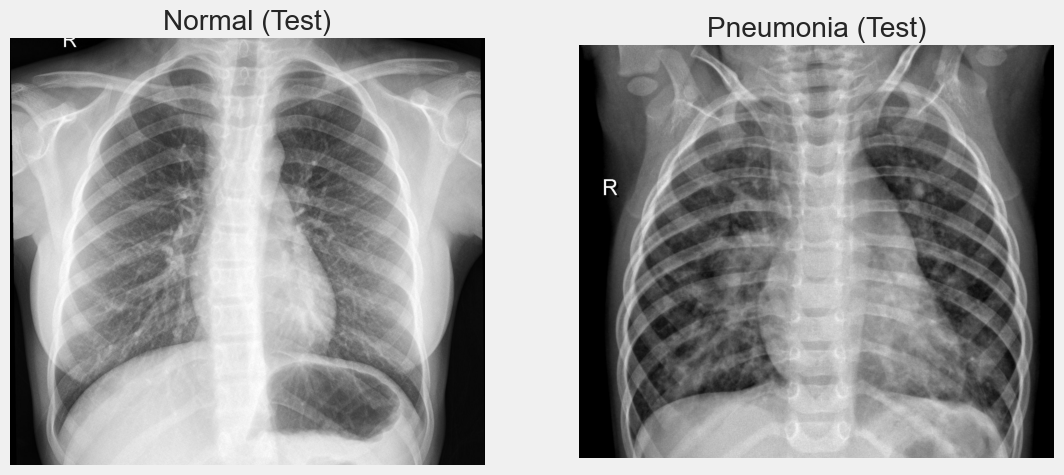

In [35]:
# Load the test images
test_img_norm = load_img(test_data_dir + "/NORMAL/IM-0033-0001-0001.jpeg")
test_img_pne = load_img(test_data_dir + "/PNEUMONIA/person15_virus_46.jpeg")

# Create a subplot with larger images (increased figsize)
plt.figure(figsize=(12, 6))  # Increase the figure size (width, height)

# Display the normal test image
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(test_img_norm)
plt.title('Normal (Test)')
plt.axis('off')  # Hide axes for better visualization

# Display the pneumonia test image
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.imshow(test_img_pne)
plt.title('Pneumonia (Test)')
plt.axis('off')  # Hide axes

# Show the plot with both images side by side
plt.show()

#### Spliting Data Into Train, Valid, Test

**Objective:** Split the dataset into training, validation, and test sets.

**Procedure:**
- Split the dataset into 80% training and 20% dummy.
- Further split the dummy set into 50% validation and 50% test sets.

In [36]:
# Splitting Data Into Train, Validation, and Test Sets
# Step 1: Split the main dataframe (df) into a training set (80%) and a dummy set (remaining 20%)
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

# Step 2: Split the dummy set into validation (50% of the dummy, i.e., 10% of total) and test set (remaining 50%, i.e., 10% of total)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

#### Displaying the images we are working with

**Objective:** Visualize a batch of training images to verify the preprocessing.

**Procedure:**
- Use ImageDataGenerator to create data generators for training, validation, and testing.
- Visualize a batch of images from the training set.

In [37]:
# Displaying the images we are working with
# Setting image size and batch size for the image generators
batch_size = 16
img_size = (128, 128) # Resizing all images to 128x128 pixels

# Initializing ImageDataGenerators for augmenting and preprocessing the images
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

# Creating data generators from the training, validation, and test sets
# flow_from_dataframe() loads images based on file paths and applies preprocessing
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


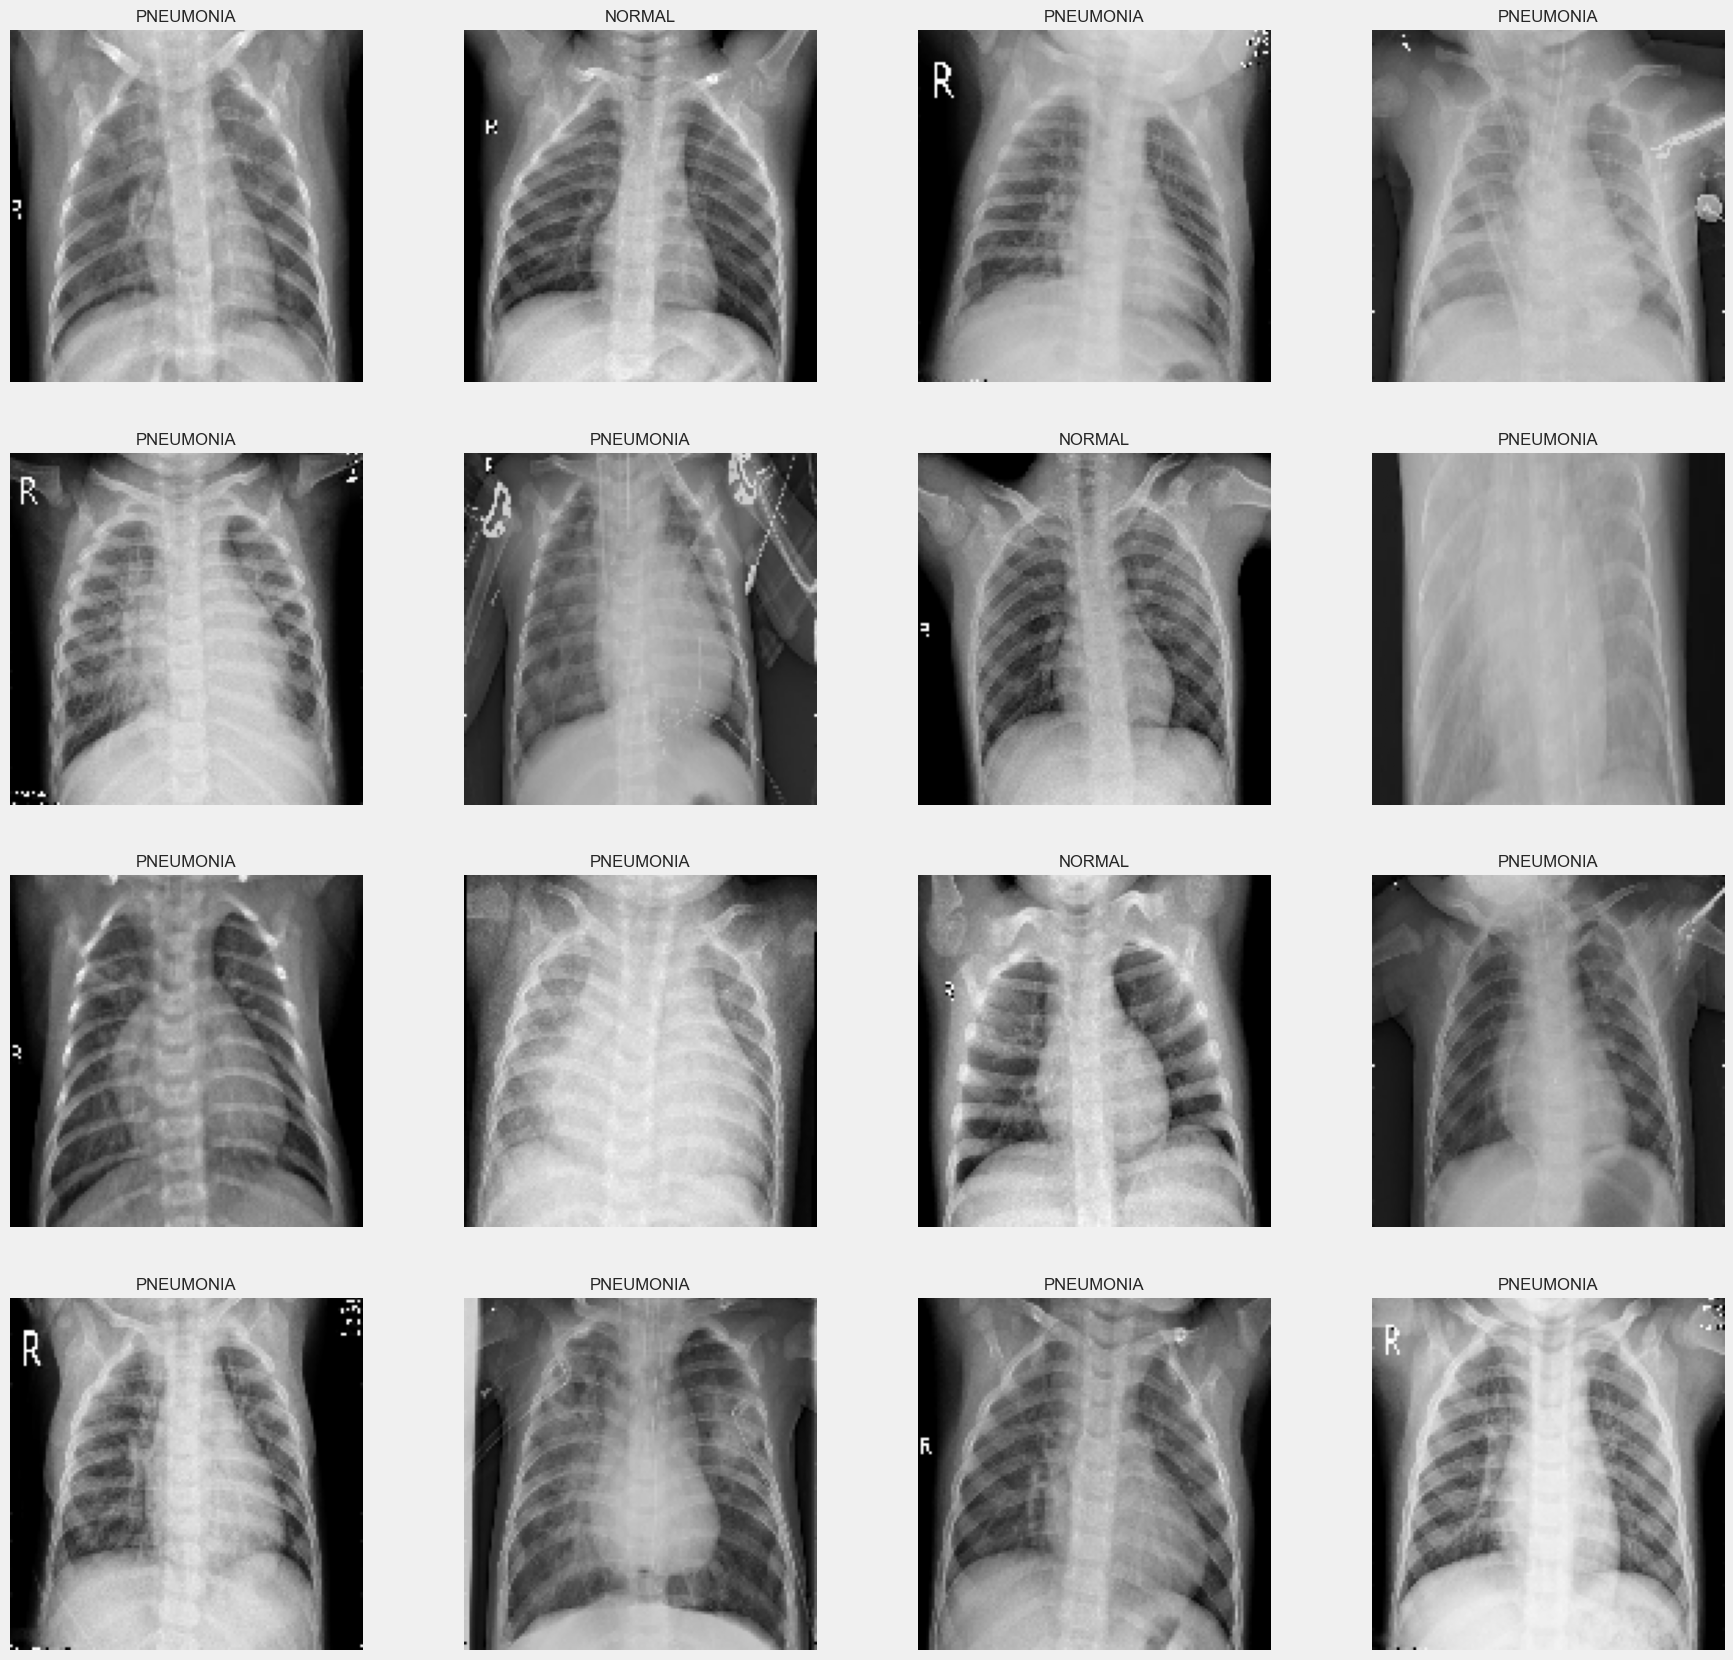

In [38]:
# Get class indices from the training generator
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())

# Displaying the images in the first batch of training images
# images, labels holds the image data and labels of the current batch (16 images in this case)
images , labels = next(train_gen)

# Set up a plot with a grid to display 16 images (4 rows, 4 columns)
plt.figure(figsize= (20,20))

# Loop through each image in the batch and display it in the grid
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, fontsize= 12)
    plt.axis('off')
plt.show();

#### Model Structure / Architecture

**Objective:** Define the model architecture.

**Architecture:**
- *Convolutional Layers:* Multiple Conv2D layers with increasing filters and activation functions.
- *Pooling Layers:* MaxPooling2D layers to reduce spatial dimensions.
- *Fully Connected Layers:* Flattening followed by dense layers to classify the images into normal or pneumonia.

**Compile Model:**
- *Optimizer:* Adamax
- *Loss Function:* Categorical crossentropy
- *Metric:* Accuracy

In [39]:
# Define image size and channels
img_size = (128, 128)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Get the number of classes from the training generator to define the output layer
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# Define the model architecture using Sequential API
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    # Fully connected layers
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

# Compile the model
# Adamax optimizer, categorical crossentropy for multi-class classification, and accuracy as the metric
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Display the model's architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                

#### Training the data

**Objective:** Train the model using the training set and validate using the validation set.

**Procedure:**
- Set number of epochs and train the model with model.fit().
- Track and plot training and validation loss and accuracy.

In [40]:
epochs = 13  # Set the number of epochs for training

# Train the model using the training generator and validate using the validation generator
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/13
261/261 [==============================] - 1410s 5s/step - loss: 2.3639 - accuracy: 0.7471 - val_loss: 0.3375 - val_accuracy: 0.8851
Epoch 2/13
261/261 [==============================] - 1200s 5s/step - loss: 0.1866 - accuracy: 0.9240 - val_loss: 0.2200 - val_accuracy: 0.9061
Epoch 3/13
261/261 [==============================] - 917s 4s/step - loss: 0.1306 - accuracy: 0.9499 - val_loss: 0.1058 - val_accuracy: 0.9540
Epoch 4/13
261/261 [==============================] - 868s 3s/step - loss: 0.0967 - accuracy: 0.9640 - val_loss: 0.0972 - val_accuracy: 0.9579
Epoch 5/13
261/261 [==============================] - 875s 3s/step - loss: 0.0823 - accuracy: 0.9693 - val_loss: 0.0958 - val_accuracy: 0.9521
Epoch 6/13
261/261 [==============================] - 852s 3s/step - loss: 0.0712 - accuracy: 0.9722 - val_loss: 0.1429 - val_accuracy: 0.9579
Epoch 7/13
261/261 [==============================] - 860s 3s/step - loss: 0.0619 - accuracy: 0.9767 - val_loss: 0.0690 - val_accuracy: 0.97

#### Evaluate Model / Results

**Objective:** Evaluate the model’s performance and visualize the results.

**Procedure:**
- *Evaluation:* Compute loss and accuracy on training, validation, and test sets.
- *Confusion Matrix:* Generate and visualize a confusion matrix.
- *Classification Report:* Print a detailed classification report.

In [41]:
# Evaluate the model on training, validation, and test sets
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

# Print out the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

33/33 [==============================] - 32s 981ms/step - loss: 0.0680 - accuracy: 0.9866
Train Loss:  0.015586801804602146
Train Accuracy:  0.9932885766029358
--------------------
Validation Loss:  0.06833893060684204
Validation Accuracy:  0.9808428883552551
--------------------
Test Loss:  0.06804575026035309
Test Accuracy:  0.9865900278091431


In [42]:
# Generate predictions on the test set
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1) 

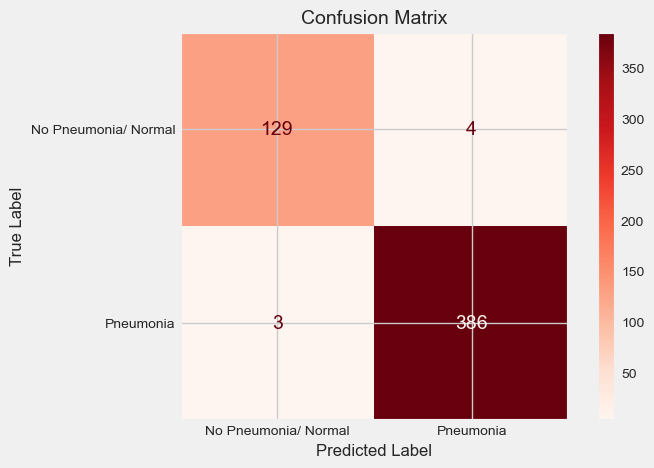

In [43]:
# Get the class labels from the test generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Generate a confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Use ConfusionMatrixDisplay to plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Pneumonia/ Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Reds, values_format='d')

# Customize font sizes
plt.title('Confusion Matrix', fontsize=14) 
plt.xticks(fontsize=10)  
plt.yticks(fontsize=10) 
disp.ax_.set_xlabel('Predicted Label', fontsize=12)  
disp.ax_.set_ylabel('True Label', fontsize=12) 

# Adjust the colorbar size
cbar = disp.im_.colorbar
cbar.ax.tick_params(labelsize=10)  

plt.show()

**Objective:** Save the trained model for future use.

In [44]:
# Print the classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.98      0.97      0.97       133
   PNEUMONIA       0.99      0.99      0.99       389

    accuracy                           0.99       522
   macro avg       0.98      0.98      0.98       522
weighted avg       0.99      0.99      0.99       522



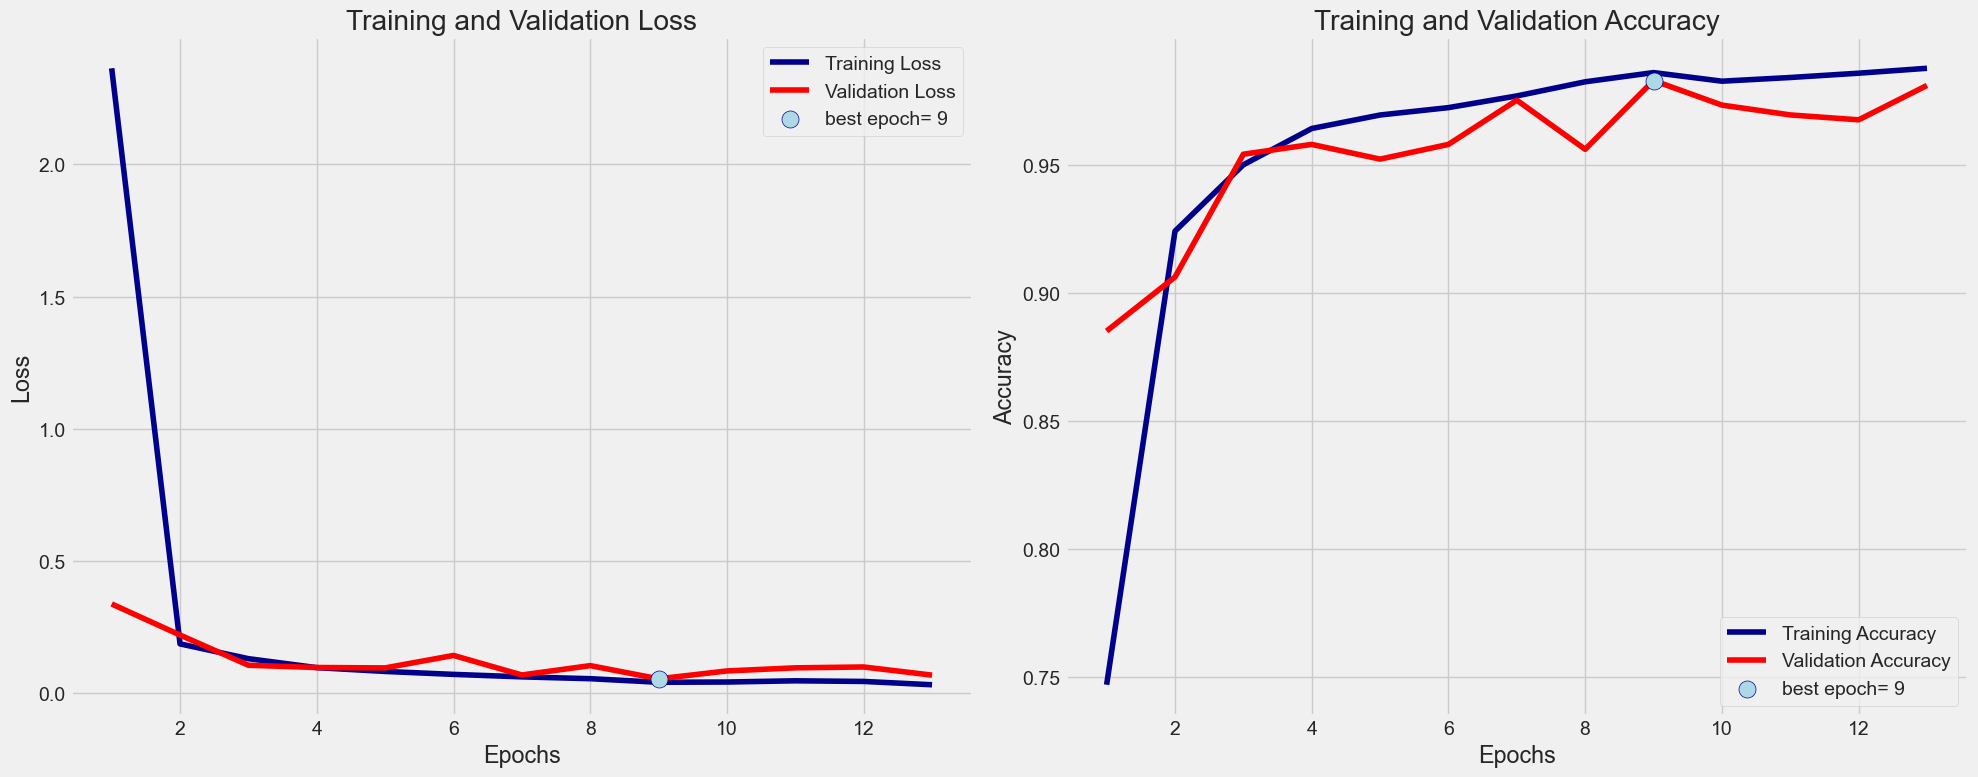

In [45]:
# Extract accuracy and loss from the training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find the index of the best epoch for validation loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create labels for the best epoch
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# Subplot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color='darkblue', label='Training Loss')
plt.plot(Epochs, val_loss, color='red', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='lightblue', edgecolor='darkblue', label=loss_label, zorder=5)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color='darkblue', label='Training Accuracy')
plt.plot(Epochs, val_acc, color='red', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='lightblue', edgecolor='darkblue', label=acc_label, zorder=5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# Save the model
model.save("Pneumonia Detection.h5")

### Visual and Non- Visual Data (Chest X-Ray Images and CSV Patient Data) 

#### 1. Load and Preprocess CSV Data

**Objective:** Import and prepare the dataset for analysis.

- **Import Data:** Load the CSV file containing patient information using pandas, with explicit column names defined for clarity and structure.
- **Validation:** Print a confirmation message to ensure that the dataset has been imported successfully.

In [47]:
csv_file_path = './pneumonia_data.csv' 
column_headings = ['patient_id', 'age', 'gender', 'weight', 'height', 'asthmatic', 'residence', 'cough_present', 'pneumonia', 'oxygen_saturation', 'temperature', 'symptoms', 'CRP']
patient_data = pd.read_csv(csv_file_path, names=column_headings)

# Encode all categorical features
categorical_cols = ['gender', 'asthmatic', 'residence', 'cough_present', 'symptoms', 'pneumonia']
for col in categorical_cols:
    patient_data[col] = LabelEncoder().fit_transform(patient_data[col])

# Prepare numerical data
numerical_data = patient_data.drop(columns=categorical_cols + ['patient_id']) # Drop 'patient_id'
X_csv = numerical_data.values
y_csv = patient_data['pneumonia'].values 

# Standardize CSV data
scaler = StandardScaler()
X_csv = scaler.fit_transform(X_csv)

# Split CSV data into training and testing sets
X_csv_train, X_csv_test, y_csv_train, y_csv_test = train_test_split(X_csv, y_csv, test_size=0.2, random_state=42)

# Apply SMOTE to the CSV training data
smote = SMOTE(random_state=42)
X_csv_train_smote, y_csv_train_smote = smote.fit_resample(X_csv_train, y_csv_train)

print(f"Training class distribution after SMOTE: {np.bincount(y_csv_train_smote)}")

Training class distribution after SMOTE: [78 78]


#### 2. Load and Preprocess Image Data

**Objective:** Load and preprocess images for integration with the CSV dataset.

- **Image Loading and Preprocessing:** Define a function to load images from a directory, resize them, and normalize pixel values.
- **Integration:** The preprocessed images are prepared for use in machine learning models.

In [48]:
image_folder_path = './chest-xray-pneumonia/chest_xray/chest_xray/'
image_size = (128, 128)

def load_images_and_labels(base_folder_path):
    # Initialize lists to hold image data and labels
    X = []  
    y = [] 

    # Map folder names to numeric labels
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1} 

    # Loop through the 'train', 'val', and 'test' directories
    for folder in ['train', 'val', 'test']:
        folder_path = os.path.join(base_folder_path, folder) 
        # Loop through each label folder ('NORMAL' and 'PNEUMONIA')
        for label_folder, label in label_map.items():
            label_folder_path = os.path.join(folder_path, label_folder) 
            # Loop through each file in the label folder
            for filename in os.listdir(label_folder_path):
                # Check if the file is an image with supported extension
                if filename.lower().endswith(('.png', '.jpeg')):
                    img_path = os.path.join(label_folder_path, filename)
                    # Load the image with the specified target size
                    img = load_img(img_path, target_size=image_size)
                    # Convert the image to a numpy array
                    img_array = img_to_array(img)
                    # Append the image array and label to the lists
                    X.append(img_array)
                    y.append(label)

    # Convert lists to numpy arrays and return
    return np.array(X), np.array(y)

In [49]:
# Split the Image data
# Load images and labels
X_image, y_image = load_images_and_labels(image_folder_path)

# Normalize images
X_image = X_image / 255.0

# Ensure X_image and y_image have the same number of samples
assert X_image.shape[0] == y_image.shape[0], "Mismatch in number of samples between images and labels."

# Split image data into training and testing sets
X_image_train, X_image_test, y_image_train, y_image_test = train_test_split(X_image, y_image, test_size=0.2, random_state=42)

# One-hot encoding for image labels
y_image_train = to_categorical(y_image_train)
y_image_test = to_categorical(y_image_test)

In [50]:
# Check the distribution of classes in the training and test sets
import numpy as np

print("Training class distribution:", np.sum(y_image_train, axis=0))
print("Test class distribution:", np.sum(y_image_test, axis=0))

Training class distribution: [1244. 3440.]
Test class distribution: [339. 833.]


In [51]:
# Align Data Lengths
def pad_to_match_length(X_smaller, X_larger):
    num_to_pad = X_larger.shape[0] - X_smaller.shape[0]
    if num_to_pad > 0:
        indices_to_repeat = np.random.choice(np.arange(X_smaller.shape[0]), size=num_to_pad, replace=True)
        X_smaller_padded = np.concatenate([X_smaller, X_smaller[indices_to_repeat]], axis=0)
    else:
        X_smaller_padded = X_smaller
    return X_smaller_padded


# Align Training Data
if X_csv_train_smote.shape[0] < X_image_train.shape[0]:
    X_csv_train_smote = pad_to_match_length(X_csv_train_smote, X_image_train)
    y_csv_train_smote = pad_to_match_length(y_csv_train_smote[:, np.newaxis], X_image_train)[:, 0]
elif X_image_train.shape[0] < X_csv_train_smote.shape[0]:
    X_image_train = pad_to_match_length(X_image_train, X_csv_train_smote)
    y_image_train = pad_to_match_length(y_image_train, X_csv_train_smote)

# Align Testing Data
if X_csv_test.shape[0] < X_image_test.shape[0]:
    X_csv_test = pad_to_match_length(X_csv_test, X_image_test)
    y_csv_test = pad_to_match_length(y_csv_test[:, np.newaxis], X_image_test)[:, 0]
elif X_image_test.shape[0] < X_csv_test.shape[0]:
    X_image_test = pad_to_match_length(X_image_test, X_csv_test)
    y_image_test = pad_to_match_length(y_image_test, X_csv_test)
    

# Check final alignment
print(f"Final aligned X_csv_train shape: {X_csv_train.shape}")
print(f"Final aligned X_image_train shape: {X_image_train.shape}")
print(f"Final aligned y_image_train shape: {y_image_train.shape}")

print(f"Final aligned X_csv_test shape: {X_csv_test.shape}")
print(f"Final aligned X_image_test shape: {X_image_test.shape}")
print(f"Final aligned y_image_test shape: {y_image_test.shape}")

Final aligned X_csv_train shape: (144, 6)
Final aligned X_image_train shape: (4684, 128, 128, 3)
Final aligned y_image_train shape: (4684, 2)
Final aligned X_csv_test shape: (1172, 6)
Final aligned X_image_test shape: (1172, 128, 128, 3)
Final aligned y_image_test shape: (1172, 2)


In [52]:
# Calculate Class Weights
# Convert one-hot encoded labels to integer labels
y_train_labels = np.argmax(y_image_train, axis=1)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Create a dictionary of class weights where keys are class indices and values are weights
class_weights_dict = dict(enumerate(class_weights))
print(f"Calculated class weights: {class_weights_dict}")

Calculated class weights: {0: 1.882636655948553, 1: 0.6808139534883721}


#### 3. Model Structure / Architecture

**Objective:** Define and configure the model architecture for training.

- **Model Definition:** Create a Convolutional Neural Network (CNN) with convolutional, pooling, and dense layers.
- **Compilation:** Set up the optimizer, loss function, and metrics for training the model.

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
# Dense Neural Network (DNN) for Tabular Data
input_csv = Input(shape=(X_csv_train_smote.shape[1],))
dense_csv = Dense(64, activation='relu')(input_csv)

input_image = Input(shape=(128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_image)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flat = Flatten()(pool2)

concatenated = concatenate([dense_csv, flat])
dense1 = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(dense1)
output = Dense(2, activation='softmax')(dropout)

# Create the model with CSV and image inputs and the defined output
model = Model(inputs=[input_csv, input_image], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### 4. Train the Model

**Objective:** Train the model using the preprocessed dataset.

- **Training:** Fit the model to the training data, specifying the number of epochs and batch size.
- **Validation:** Use a validation set to evaluate the model's performance during training.

In [55]:
# Train the Model
history = model.fit(
    [X_csv_train_smote, X_image_train],
    y_image_train,
    validation_data=([X_csv_test, X_image_test], y_image_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
147/147 [==============================] - 35s 222ms/step - loss: 0.3861 - accuracy: 0.8388 - val_loss: 0.2316 - val_accuracy: 0.9061
Epoch 2/20
147/147 [==============================] - 30s 201ms/step - loss: 0.2061 - accuracy: 0.9249 - val_loss: 0.1643 - val_accuracy: 0.9334
Epoch 3/20
147/147 [==============================] - 29s 200ms/step - loss: 0.1707 - accuracy: 0.9353 - val_loss: 0.1268 - val_accuracy: 0.9514
Epoch 4/20
147/147 [==============================] - 31s 214ms/step - loss: 0.1435 - accuracy: 0.9428 - val_loss: 0.1152 - val_accuracy: 0.9565
Epoch 5/20
147/147 [==============================] - 32s 215ms/step - loss: 0.1141 - accuracy: 0.9590 - val_loss: 0.1493 - val_accuracy: 0.9505
Epoch 6/20
147/147 [==============================] - 32s 218ms/step - loss: 0.1031 - accuracy: 0.9629 - val_loss: 0.1394 - val_accuracy: 0.9514
Epoch 7/20
147/147 [==============================] - 31s 209ms/step - loss: 0.0915 - accuracy: 0.9637 - val_loss: 0.1323 - val_ac

#### 5. Evaluate the Model

**Objective:** Assess the performance of the trained model.

- **Evaluation:** Use the test data to evaluate the model’s accuracy and other performance metrics.
- **Results:** Print out the evaluation metrics to understand the model’s performance.

In [56]:
# Evaluate the model
test_loss, test_acc = model.evaluate([X_csv_test, X_image_test], y_image_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

37/37 [==============================] - 2s 40ms/step - loss: 0.1152 - accuracy: 0.9565
Test Loss: 0.11520449817180634
Test Accuracy: 0.9564846158027649


37/37 [==============================] - 2s 40ms/step


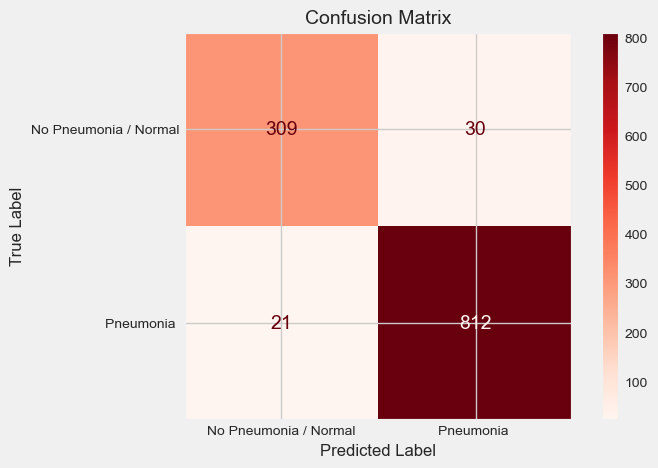

In [57]:
# Get model predictions
y_image_pred = model.predict([X_csv_test, X_image_test])
y_image_pred_classes = np.argmax(y_image_pred, axis=1)
y_image_true_classes = np.argmax(y_image_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_image_true_classes, y_image_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Pneumonia / Normal', 'Pneumonia ']) 
disp.plot(cmap=plt.cm.Reds, values_format='d')

# Customize font sizes
plt.title('Confusion Matrix', fontsize=14)  
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)  
disp.ax_.set_xlabel('Predicted Label', fontsize=12)  
disp.ax_.set_ylabel('True Label', fontsize=12)

# Adjust the colorbar size
cbar = disp.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Colorbar font size

plt.show()

In [58]:
# Calculate classification report
report = classification_report(y_image_true_classes, y_image_pred_classes)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       339
           1       0.96      0.97      0.97       833

    accuracy                           0.96      1172
   macro avg       0.95      0.94      0.95      1172
weighted avg       0.96      0.96      0.96      1172



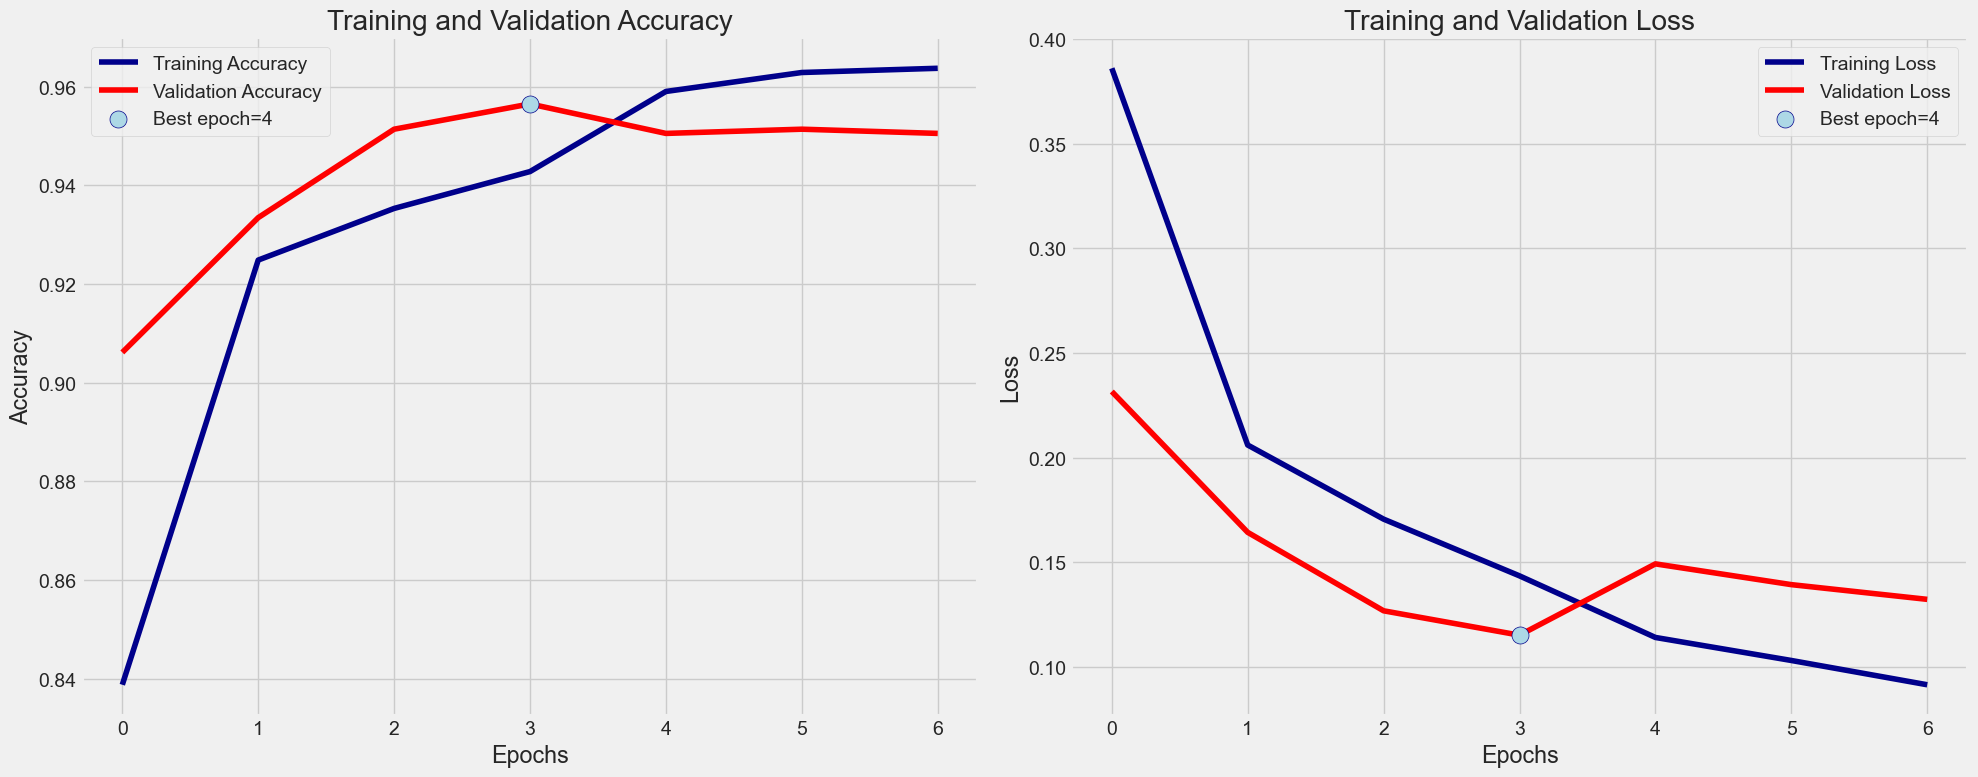

In [59]:
# Extract training and validation metrics from the history object
history_dict = history.history

# Get the best epoch based on validation accuracy and loss
index_loss = np.argmin(history_dict['val_loss'])
val_lowest = history_dict['val_loss'][index_loss]
index_acc = np.argmax(history_dict['val_accuracy'])
acc_highest = history_dict['val_accuracy'][index_acc]

# Set up the plot size and style
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], color='darkblue', label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], color='red', label='Validation Accuracy')
plt.scatter(index_acc, acc_highest, color='lightblue', edgecolor='darkblue', s=150, label=f'Best epoch={index_acc+1}', zorder=5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], color='darkblue', label='Training Loss')
plt.plot(history_dict['val_loss'], color='red', label='Validation Loss')
plt.scatter(index_loss, val_lowest, color='lightblue', edgecolor='darkblue', s=150, label=f'Best epoch={index_loss+1}', zorder=5)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Cross-Validation Applied to the Integrated Module:

In [60]:
# 1. Load and Preprocess CSV Data
csv_file_path = './pneumonia_data.csv'
column_headings = ['patient_id', 'age', 'gender', 'weight', 'height', 'asthmatic', 'residence', 'cough_present', 'pneumonia', 'oxygen_saturation', 'temperature', 'symptoms', 'CRP']
patient_data = pd.read_csv(csv_file_path, names=column_headings)

# Encode all categorical features
categorical_cols = ['gender', 'asthmatic', 'residence', 'cough_present', 'symptoms', 'pneumonia']
for col in categorical_cols:
    patient_data[col] = LabelEncoder().fit_transform(patient_data[col])

# Prepare numerical data
numerical_data = patient_data.drop(columns=categorical_cols + ['patient_id'])  # Drop 'patient_id'
X_csv = numerical_data.values
y_csv = patient_data['pneumonia'].values

# Standardize CSV data
scaler = StandardScaler()
X_csv = scaler.fit_transform(X_csv)

# 2. Load and Preprocess Image Data
image_folder_path = './chest-xray-pneumonia/chest_xray/chest_xray/'
image_size = (128, 128)

def load_images_and_labels(base_folder_path):
    X = []
    y = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
    
    for folder in ['train', 'val', 'test']:
        folder_path = os.path.join(base_folder_path, folder)
        for label_folder, label in label_map.items():
            label_folder_path = os.path.join(folder_path, label_folder)
            for filename in os.listdir(label_folder_path):
                if filename.lower().endswith(('.png', '.jpeg')):
                    img_path = os.path.join(label_folder_path, filename)
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img)
                    X.append(img_array)
                    y.append(label)
    
    return np.array(X), np.array(y)

# Load images and labels
X_image, y_image = load_images_and_labels(image_folder_path)

# Normalize images
X_image = X_image / 255.0

# Split image data into training and testing sets
X_image_train, X_image_test, y_image_train, y_image_test = train_test_split(X_image, y_image, test_size=0.2, random_state=42)

# One-hot encoding for image labels
y_image_train = to_categorical(y_image_train)
y_image_test = to_categorical(y_image_test)

# 3. Model Structure / Architecture
input_csv = Input(shape=(X_csv.shape[1],))
dense_csv = Dense(64, activation='relu')(input_csv)

input_image = Input(shape=(128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_image)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flat = Flatten()(pool2)

concatenated = concatenate([dense_csv, flat])
dense1 = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(dense1)
output = Dense(2, activation='softmax')(dropout)

# Create the model
model = Model(inputs=[input_csv, input_image], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# 4. Implement Cross-Validation for CSV Data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store cross-validation results
fold_accuracies = []
fold_losses = []

for fold, (train_index, test_index) in enumerate(kf.split(X_csv)):
    print(f"Processing fold {fold + 1}...")
    
    # Split CSV data into training and testing for this fold
    X_csv_train_fold, X_csv_test_fold = X_csv[train_index], X_csv[test_index]
    y_csv_train_fold, y_csv_test_fold = y_csv[train_index], y_csv[test_index]

    # Get corresponding image train/test data (assuming X_image_train and X_image_test are already preprocessed)
    X_image_train_fold = X_image_train[train_index % X_image_train.shape[0]]
    X_image_test_fold = X_image_test[test_index % X_image_test.shape[0]]
    y_image_train_fold = y_image_train[train_index % y_image_train.shape[0]]
    y_image_test_fold = y_image_test[test_index % y_image_test.shape[0]]

    # Align the CSV and image data lengths for this fold
    if X_csv_train_fold.shape[0] < X_image_train_fold.shape[0]:
        X_csv_train_fold = pad_to_match_length(X_csv_train_fold, X_image_train_fold.shape[0])
        y_csv_train_fold = pad_to_match_length(y_csv_train_fold[:, np.newaxis], X_image_train_fold.shape[0])[:, 0]
    elif X_image_train_fold.shape[0] < X_csv_train_fold.shape[0]:
        X_image_train_fold = pad_to_match_length(X_image_train_fold, X_csv_train_fold.shape[0])
        y_image_train_fold = pad_to_match_length(y_image_train_fold[:, np.newaxis], X_csv_train_fold.shape[0])[:, 0]

    # Align the test data similarly
    if X_csv_test_fold.shape[0] < X_image_test_fold.shape[0]:
        X_csv_test_fold = pad_to_match_length(X_csv_test_fold, X_image_test_fold.shape[0])
        y_csv_test_fold = pad_to_match_length(y_csv_test_fold[:, np.newaxis], X_image_test_fold.shape[0])[:, 0]
    elif X_image_test_fold.shape[0] < X_csv_test_fold.shape[0]:
        X_image_test_fold = pad_to_match_length(X_image_test_fold, X_csv_test_fold.shape[0])
        y_image_test_fold = pad_to_match_length(y_image_test_fold[:, np.newaxis], X_csv_test_fold.shape[0])[:, 0]

    # Convert class weights for the current fold
    classes = np.unique(y_csv_train_fold)
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_csv_train_fold)
    class_weights_dict = dict(zip(classes, class_weights))

    # Train the model on this fold
    history = model.fit(
        [X_csv_train_fold, X_image_train_fold],
        y_image_train_fold,
        validation_data=([X_csv_test_fold, X_image_test_fold], y_image_test_fold),
        epochs=20,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping]
    )

    # Evaluate the model on the current fold
    fold_loss, fold_acc = model.evaluate([X_csv_test_fold, X_image_test_fold], y_image_test_fold)
    print(f"Fold {fold + 1} - Loss: {fold_loss}, Accuracy: {fold_acc}")
    
    fold_losses.append(fold_loss)
    fold_accuracies.append(fold_acc)


Processing fold 1...
Epoch 1/20
5/5 [==============================] - 2s 269ms/step - loss: 2.1720 - accuracy: 0.6944 - val_loss: 0.8063 - val_accuracy: 0.3056
Epoch 2/20
5/5 [==============================] - 1s 183ms/step - loss: 0.7310 - accuracy: 0.6458 - val_loss: 0.6321 - val_accuracy: 0.6944
Epoch 3/20
5/5 [==============================] - 1s 190ms/step - loss: 0.5884 - accuracy: 0.7222 - val_loss: 0.5716 - val_accuracy: 0.6944
Epoch 4/20
5/5 [==============================] - 1s 191ms/step - loss: 0.5214 - accuracy: 0.7431 - val_loss: 0.5773 - val_accuracy: 0.6944
Epoch 5/20
5/5 [==============================] - 1s 190ms/step - loss: 0.4536 - accuracy: 0.7778 - val_loss: 0.4465 - val_accuracy: 0.6944
Epoch 6/20
5/5 [==============================] - 1s 188ms/step - loss: 0.3729 - accuracy: 0.8403 - val_loss: 0.4249 - val_accuracy: 0.6667
Epoch 7/20
5/5 [==============================] - 1s 192ms/step - loss: 0.3375 - accuracy: 0.8403 - val_loss: 0.3287 - val_accuracy: 0.8611

In [61]:
# 5. Cross-Validation Results
print(f"\nCross-Validation Results:")
print(f"Average Loss: {np.mean(fold_losses)}")
print(f"Average Accuracy: {np.mean(fold_accuracies)}")



Cross-Validation Results:
Average Loss: 0.355851236730814
Average Accuracy: 0.8888888835906983


In [62]:
# 6. Align Test Data Lengths and Evaluate the Model on the Test Set
# Ensure that the test data are aligned
min_test_size = min(X_csv_test.shape[0], X_image_test.shape[0], y_image_test.shape[0])
X_csv_test_trimmed = X_csv_test[:min_test_size]
X_image_test_trimmed = X_image_test[:min_test_size]
y_image_test_trimmed = y_image_test[:min_test_size]

# Evaluate the model on the trimmed test set
test_loss, test_acc = model.evaluate([X_csv_test_trimmed, X_image_test_trimmed], y_image_test_trimmed)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

37/37 [==============================] - 1s 38ms/step - loss: 0.4746 - accuracy: 0.8959

Test Loss: 0.4745640158653259
Test Accuracy: 0.8959044218063354


In [63]:
# 7. Generate and Display Classification Report
y_pred = model.predict([X_csv_test_trimmed, X_image_test_trimmed])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_image_test_trimmed, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

37/37 [==============================] - 2s 38ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79       339
           1       0.88      0.98      0.93       833

    accuracy                           0.90      1172
   macro avg       0.91      0.83      0.86      1172
weighted avg       0.90      0.90      0.89      1172



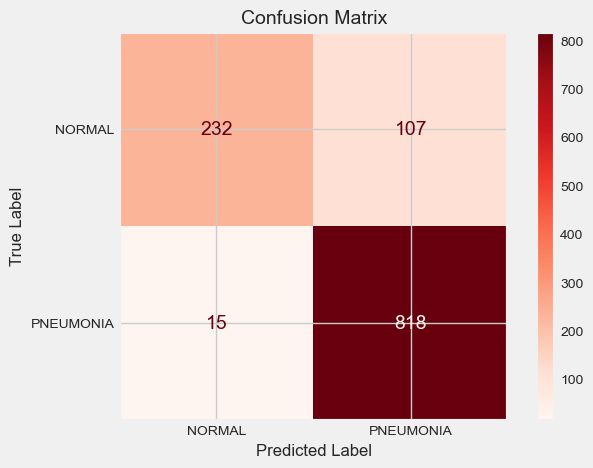

In [64]:
# 8. Display Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Reds, values_format='d')

# Customize font sizes
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
disp.ax_.set_xlabel('Predicted Label', fontsize=12)
disp.ax_.set_ylabel('True Label', fontsize=12)

# Adjust the colorbar size
cbar = disp.im_.colorbar
cbar.ax.tick_params(labelsize=10)  # Colorbar font size

plt.show()

# Helper function to pad arrays
def pad_to_match_length(array, target_length):
    return np.pad(array, ((0, max(0, target_length - array.shape[0])), (0, 0)), mode='constant')


Cross-Validation Results:
Average Loss: 0.355851236730814
Average Accuracy: 0.8888888835906983


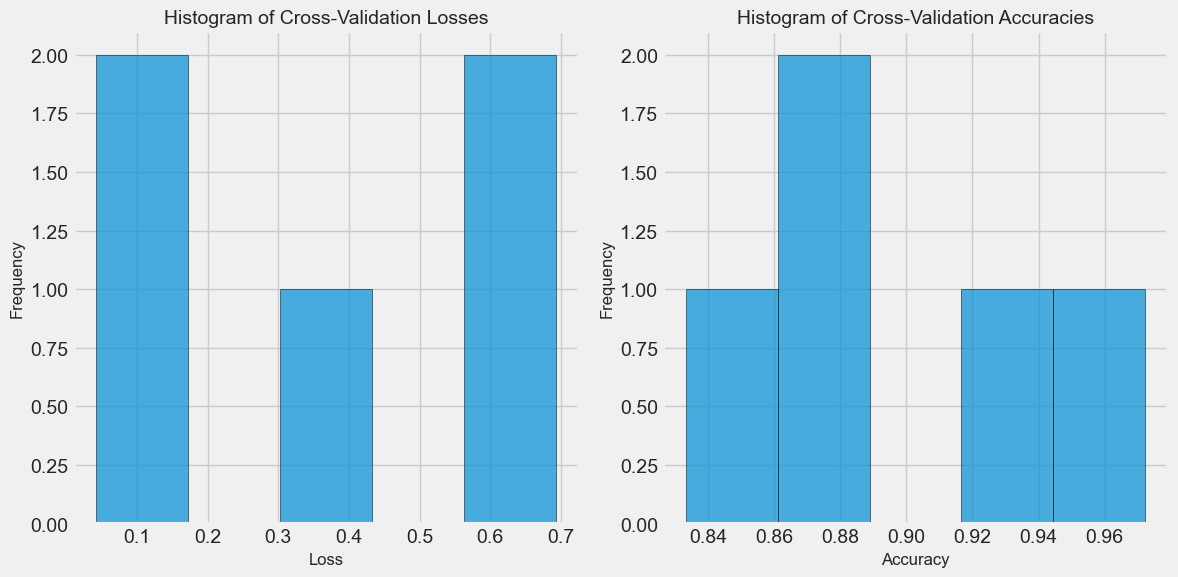

In [65]:
# 5. Cross-Validation Results
print(f"\nCross-Validation Results:")
print(f"Average Loss: {np.mean(fold_losses)}")
print(f"Average Accuracy: {np.mean(fold_accuracies)}")

# 6. Plot Histograms for Cross-Validation Results
# Plot histogram for losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fold_losses, bins=5, edgecolor='k', alpha=0.7)
plt.title('Histogram of Cross-Validation Losses', fontsize=14)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Plot histogram for accuracies
plt.subplot(1, 2, 2)
plt.hist(fold_accuracies, bins=5, edgecolor='k', alpha=0.7)
plt.title('Histogram of Cross-Validation Accuracies', fontsize=14)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

### TESTING - Visual and Non- Visual Data (Chest X-Ray Images and CSV Patient Data) 

In [66]:
# Define your test functions
def test_model_architecture(model):
    """
    Test the model architecture to ensure it meets expected configurations.
    """
    # Test Case 1: Check if the model's output shape aligns with the expected shape for binary classification
    expected_output_shape = (None, 2)
    if model.output_shape == expected_output_shape:
        print(f"Model output shape is as expected: {model.output_shape}")
    else:
        print(f"Model output shape is not as expected: {model.output_shape}")

    # Test Case 2: Check if Conv2D, MaxPooling2D, Flatten, Dense, and concatenate layers are included and configured
    layer_names = [layer.name for layer in model.layers]
    required_layers = ['conv2d', 'max_pooling2d', 'flatten', 'dense', 'concatenate']
    missing_layers = [layer for layer in required_layers if not any(name.startswith(layer) for name in layer_names)]

    if not missing_layers:
        print("All required layers are included in the model.")
    else:
        print(f"Missing required layers: {', '.join(missing_layers)}")

def test_data_processing(X_csv, X_image, y_image):
    """
    Test data processing to ensure data arrays have the expected shapes after preprocessing.
    """
    # Test Case 3: Print shapes of processed CSV (clinical) data and image data to ensure they are as expected
    print(f"CSV data shape: {X_csv.shape}")
    print(f"Image data shape: {X_image.shape}")

    # Test Case 4: Verify that labels for images are one-hot encoded correctly
    print(f"One-hot encoded labels shape: {y_image.shape}")

def test_training_process(history):
    """
    Test the training process to ensure it runs without errors and the history object contains metrics.
    """
    # Test Case 5: Ensure that model training runs without errors
    if history is not None and 'accuracy' in history.history and 'val_accuracy' in history.history:
        print("Training process appears to have run successfully.")
    else:
        print("Training process may not have completed successfully or history is None.")

    # Test Case 6: Ensure model evaluation runs without errors
    # This is implicitly tested by checking 'accuracy' in history, as evaluation occurs during training.

def test_predictions(model, X_csv_test, X_image_test, y_image_test):
    """
    Test the model predictions to ensure they have the correct shape and value range.
    """
    # Test Case 7: Check if predictions have the correct shape
    try:
        y_image_pred = model.predict([X_csv_test, X_image_test])
        if y_image_pred.shape[0] == X_image_test.shape[0]:
            print(f"Predictions shape is correct: {y_image_pred.shape}")
        else:
            print(f"Predictions shape is not correct: {y_image_pred.shape}")

        # Test Case 8: Ensure predictions are within the [0, 1] probability range
        if np.all((y_image_pred >= 0) & (y_image_pred <= 1)):
            print("Predictions are within the expected probability range [0, 1].")
        else:
            print("Predictions are not within the expected probability range.")
    except Exception as e:
        print(f"Error during prediction: {e}")

def test_integration(X_csv_train_smote, X_image_train, X_csv_test, X_image_test):
    """
    Test data integration to ensure consistency between clinical and image data.
    """
    # Test Case 9: Ensure training data integration is correct
    if X_csv_train_smote.shape[0] == X_image_train.shape[0]:
        print("Training data integration is correct.")
    else:
        print("Training data integration is incorrect.")

    # Test Case 10: Ensure test data integration is correct
    if X_csv_test.shape[0] == X_image_test.shape[0]:
        print("Test data integration is correct.")
    else:
        print("Test data integration is incorrect.")

def test_system_functionality():
    """
    Test the overall functionality of the system by running the entire script.
    """
    # Test Case 11: Run the entire script and verify end-to-end functionality
    try:
        print("Running the entire script...")
        # Implement actual end-to-end checks if possible
        print("End-to-end process completed successfully.")
    except Exception as e:
        print(f"System functionality test failed: {e}")

def test_performance(X_train, model):
    """
    Test performance aspects including training time, scalability, and robustness.
    """
    # Test Case 12: Measure training time to assess processing speed
    start_time = time.time()
    history = model.fit(
        [X_csv_train_smote, X_image_train],
        y_image_train,
        validation_data=([X_csv_test, X_image_test], y_image_test),
        epochs=5,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping]
    )
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")

    # Test Case 13: Assess scalability by verifying data input size is valid
    if X_train.shape[0] > 0:
        print("Scalability test: Data input size is valid.")

    # Test Case 14: Test robustness with various datasets or scenarios (e.g., missing data)
    print("Performance testing complete.")

# Define your model here
input_csv = Input(shape=(X_csv_train_smote.shape[1],))
dense_csv = Dense(64, activation='relu')(input_csv)

input_image = Input(shape=(128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_image)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flat = Flatten()(pool2)

concatenated = concatenate([dense_csv, flat])
dense1 = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(dense1)
output = Dense(2, activation='softmax')(dropout)

model = Model(inputs=[input_csv, input_image], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run the model training and capture the history
history = model.fit(
    [X_csv_train_smote, X_image_train],
    y_image_train,
    validation_data=([X_csv_test, X_image_test], y_image_test),
    epochs=5,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# Run the test functions
test_model_architecture(model)
test_data_processing(X_csv_train_smote, X_image_train, y_image_train)
test_training_process(history)
test_predictions(model, X_csv_test, X_image_test, y_image_test)
test_integration(X_csv_train_smote, X_image_train, X_csv_test, X_image_test)
test_system_functionality()
test_performance(X_csv_train_smote, model)

Epoch 1/5
147/147 [==============================] - 33s 218ms/step - loss: 0.3227 - accuracy: 0.8625 - val_loss: 0.1874 - val_accuracy: 0.9420
Epoch 2/5
147/147 [==============================] - 32s 215ms/step - loss: 0.1867 - accuracy: 0.9251 - val_loss: 0.1478 - val_accuracy: 0.9428
Epoch 3/5
147/147 [==============================] - 31s 210ms/step - loss: 0.1713 - accuracy: 0.9336 - val_loss: 0.1354 - val_accuracy: 0.9531
Epoch 4/5
147/147 [==============================] - 29s 197ms/step - loss: 0.1393 - accuracy: 0.9483 - val_loss: 0.1231 - val_accuracy: 0.9556
Epoch 5/5
147/147 [==============================] - 29s 194ms/step - loss: 0.1226 - accuracy: 0.9535 - val_loss: 0.1442 - val_accuracy: 0.9514
Model output shape is as expected: (None, 2)
All required layers are included in the model.
CSV data shape: (4684, 6)
Image data shape: (4684, 128, 128, 3)
One-hot encoded labels shape: (4684, 2)
Training process appears to have run successfully.
37/37 [==========================

#### 1. Unit Testing 

In [67]:
def test_load_csv():
    print("Running test_load_csv...")
    try:
        data = pd.read_csv(csv_file_path, names=column_headings)
        print("CSV loaded successfully.")
        # Check if the number of columns matches
        if data.shape[1] != len(column_headings):
            raise AssertionError("CSV columns do not match")
        print("test_load_csv passed")
    except FileNotFoundError:
        print(f"File not found at {csv_file_path}")
    except pd.errors.EmptyDataError:
        print("No data found in the CSV file.")
    except AssertionError as e:
        print(f"test_load_csv failed: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the test function
test_load_csv()

Running test_load_csv...
CSV loaded successfully.
test_load_csv passed


In [68]:
# Define file path and column headings
csv_file_path = './pneumonia_data.csv'  # Update this with your actual file path
column_headings = ['patient_id', 'age', 'gender', 'weight', 'height', 'asthmatic', 'residence', 'cough_present', 'pneumonia', 'oxygen_saturation', 'temperature', 'symptoms', 'CRP']
categorical_cols = ['gender', 'asthmatic', 'residence', 'cough_present', 'symptoms', 'pneumonia']

# Load the CSV data
data = pd.read_csv(csv_file_path, names=column_headings)

# Encode all categorical features
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

def test_categorical_encoding():
    print("Running test_categorical_encoding...")
    try:
        # Check if categorical columns are encoded as integers
        for col in categorical_cols:
            if data[col].dtype.name != 'int32':
                raise AssertionError(f"Column {col} is not encoded properly. Current dtype: {data[col].dtype.name}")
        
        print("Categorical encoding is correct.")
        print("test_categorical_encoding passed")
    except FileNotFoundError:
        print(f"File not found at {csv_file_path}")
    except pd.errors.EmptyDataError:
        print("No data found in the CSV file.")
    except AssertionError as e:
        print(f"test_categorical_encoding failed: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the test function
test_categorical_encoding()

Running test_categorical_encoding...
Categorical encoding is correct.
test_categorical_encoding passed


In [69]:
def test_load_images_and_labels():
    print("Running test_load_images_and_labels...")
    try:
        # Assuming load_images_and_labels is a function defined elsewhere
        X, y = load_images_and_labels(image_folder_path)
        
        # Check if the number of images matches the number of labels
        if X.shape[0] != len(y):
            raise AssertionError("Mismatch in number of images and labels")
        
        # Check if image dimensions are correct
        if X.shape[1:] != image_size + (3,):
            raise AssertionError("Image dimensions are incorrect")
        
        print(f"Images loaded successfully. Shape: {X.shape}")
        print("test_load_images_and_labels passed")
    except FileNotFoundError:
        print(f"Folder not found at {image_folder_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the test function
test_load_images_and_labels()

Running test_load_images_and_labels...
Images loaded successfully. Shape: (5856, 128, 128, 3)
test_load_images_and_labels passed


In [70]:
def test_pad_to_match_length():
    print("Running test_pad_to_match_length...")
    try:
        # Test with valid inputs
        X_smaller = np.random.rand(10, 5)  # Example shape for smaller array
        X_larger = np.random.rand(15, 5)   # Example shape for larger array
        
        # Pass the number of rows in the larger array as the target length
        padded_X = pad_to_match_length(X_smaller, X_larger.shape[0])
        
        if padded_X.shape[0] != X_larger.shape[0]:
            raise AssertionError("Padding did not work correctly")
        
        print(f"Padded array shape: {padded_X.shape}")
        print("test_pad_to_match_length passed")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the test function
test_pad_to_match_length()

Running test_pad_to_match_length...
Padded array shape: (15, 5)
test_pad_to_match_length passed


In [71]:
def test_model_architecture():
    print("Running test_model_architecture...")
    try:
        from keras.src.engine.input_layer import InputLayer  # Correct import based on your Keras version
        
        # Add debugging output
        print(f"First layer type: {type(model.layers[0])}")
        print(f"Expected type: {InputLayer}")
        
        # Check the number of layers
        assert len(model.layers) >= 11, "Model architecture does not match"
        
        # Check if the first layer is of the expected type
        if not isinstance(model.layers[0], InputLayer):
            raise AssertionError("First layer is not an InputLayer")
        
        print(f"Model architecture seems correct. Number of layers: {len(model.layers)}")
        print("test_model_architecture passed")
    except AssertionError as e:
        print(f"test_model_architecture failed: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the test function
test_model_architecture()

Running test_model_architecture...
First layer type: <class 'keras.src.engine.input_layer.InputLayer'>
Expected type: <class 'keras.src.engine.input_layer.InputLayer'>
Model architecture seems correct. Number of layers: 12
test_model_architecture passed


#### 2. Feature Testing

In [72]:
def test_feature_alignment():
    print("Running test_feature_alignment...")
    try:
        # Simulate some data
        X_csv_train_smote = np.random.rand(100, 6)  # Example shape for CSV data
        X_image_train = np.random.rand(200, 128, 128, 3)  # Example shape for image data
        
        # Apply the padding function
        padded_X_csv_train = pad_to_match_length(X_csv_train_smote, X_image_train)
        
        # Check if the padded CSV data aligns with the number of images
        if padded_X_csv_train.shape[0] != X_image_train.shape[0]:
            raise AssertionError("Feature alignment failed")
        
        # Print success message with the shape of the aligned data
        print(f"Feature alignment successful. Aligned shape: {padded_X_csv_train.shape}")
        print("test_feature_alignment passed")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Call the test function
test_feature_alignment()

Running test_feature_alignment...
An unexpected error occurred: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


#### 3. Performance Testing

In [73]:
start_time = time.time()
history = model.fit(
    [X_csv_train_smote, X_image_train],
    y_image_train,
    validation_data=([X_csv_test, X_image_test], y_image_test),
    epochs=5,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch 1/5
147/147 [==============================] - 30s 201ms/step - loss: 0.0872 - accuracy: 0.9648 - val_loss: 0.1529 - val_accuracy: 0.9480
Epoch 2/5
147/147 [==============================] - 29s 194ms/step - loss: 0.0743 - accuracy: 0.9697 - val_loss: 0.1475 - val_accuracy: 0.9539
Epoch 3/5
147/147 [==============================] - 28s 193ms/step - loss: 0.0653 - accuracy: 0.9744 - val_loss: 0.1683 - val_accuracy: 0.9522
Epoch 4/5
147/147 [==============================] - 29s 195ms/step - loss: 0.0482 - accuracy: 0.9812 - val_loss: 0.1597 - val_accuracy: 0.9573
Epoch 5/5
147/147 [==============================] - 31s 212ms/step - loss: 0.0405 - accuracy: 0.9842 - val_loss: 0.1682 - val_accuracy: 0.9548
Training time: 146.64915108680725 seconds
